<h1> CSCI316 - Group Assignment 2 (Group 7) </h1>

<h2> Group Members: </h2>


*   Wootaek Lim (7898848)
*   Chew Wei Hong (7911130)
*   Minseo Yun (8225746)
*   Yam Shi Xuan Jonathan (8380053)


---



<h2> Objective </h2>
>The objective of this task is to develop an end-to-end data mining project by using the Apache MLlib library.

<h2> Task </h2>
>Given a person’s credit-related information, build a machine learning model that can classify the credit score.

<h2> Algorithm used: </h2>

1.   **Logistic Regression**
2.   **Artificial Neural Networks (ANN) - Multilayer Perceptron (MLP)**
3.   **Decision Tree**
4.   **Random Forest**

<h2> Table of contents </h2>




1.   Summary
2.   Importing Related Libraries
3.   Data Exploration
4.   Data Pre-processing
5.   Implementing the different models
6.   Model Evaluation






---



# 1. Summary

The goal of the Credit Score Classification project was to provide a reliable and precise method for credit score classification.

In order to obtain understanding of the dataset, the project started with an exploratory data analysis (EDA) phase. After the EDA, missing value management, duplication removal, and fixing any flaws or inconsistencies in the dataset were all part of the data cleaning process. To prepare the data for modeling, further data transformation techniques were used, such as feature scaling and categorical variable encoding.

The goal of the model creation and assessment phase was to create at least classification models that could correctly predict the categories of credit scores. Four algorithms, including  **Logistic Regression, ANN, Decision Tree, and Random Forest** were tested and their performance assessed. To address the issue of class imbalance, techniques such as resampling the minority classes was employed. Metrics like accuracy, precision, recall, and F1-score were evaluated as part of the model evaluation process to gauge the model's performance and make sure it could accurately identify credit ratings.



---



# 2. Importing Related Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import StringIndexer, StandardScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, MultilayerPerceptronClassifier, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics

In [2]:
# Set up the spark environment
conf = SparkConf().setAppName("CSCI316")
conf = (conf.setMaster('local[*]')
        .set('spark.executor.memory', '32G')
        .set('spark.driver.memory', '32G')
        .set('spark.driver.maxResultSize', '32G'))
sc = SparkContext(conf=conf)
sc.setLogLevel("OFF")
spark = SparkSession(sc)

24/02/18 16:13:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/18 16:13:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/02/18 16:13:14 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/02/18 16:13:14 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/02/18 16:13:14 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
24/02/18 16:13:14 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
24/02/18 16:13:14 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port 4045.
24/02/18 16:13:14 WARN Utils: Service 'SparkUI' could not bind on port 4045. Attempting port 4046.


# 3. Data Exploration

## Getting basic understanding of the data set

In [3]:
preview_dataframe = pd.read_csv('train.csv')

In [4]:
preview_dataframe.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [5]:
print(f"Train data size: {preview_dataframe.shape}")

Train data size: (100000, 28)


In [6]:
preview_dataframe.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score'],
      dtype='object')

In [7]:
preview_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

In [8]:
preview_dataframe.describe().T

,count,mean,std,min,25%,50%,75%,max
Monthly_Inhand_Salary,84998.0,4194.170850,3183.686167,303.645417,1625.568229,3093.745000,5957.448333,15204.633333
Num_Bank_Accounts,100000.0,17.091280,117.404834,-1.000000,3.000000,6.000000,7.000000,1798.000000
Num_Credit_Card,100000.0,22.474430,129.057410,0.000000,4.000000,5.000000,7.000000,1499.000000
Interest_Rate,100000.0,72.466040,466.422621,1.000000,8.000000,13.000000,20.000000,5797.000000
Delay_from_due_date,100000.0,21.068780,14.860104,-5.000000,10.000000,18.000000,28.000000,67.000000
Num_Credit_Inquiries,98035.0,27.754251,193.177339,0.000000,3.000000,6.000000,9.000000,2597.000000
Credit_Utilization_Ratio,100000.0,32.285173,5.116875,20.000000,28.052567,32.305784,36.496663,50.000000
Total_EMI_per_month,100000.0,1403.118217,8306.041270,0.000000,30.306660,69.249473,161.224249,82331.000000


In [9]:
preview_dataframe.describe(exclude = np.number).T

,count,unique,top,freq
ID,100000,100000,0x25fb6,1
Customer_ID,100000,12500,CUS_0x942c,8
Month,100000,8,January,12500
Name,90015,10139,Langep,44
Age,100000,1788,38,2833
SSN,100000,12501,#F%$D@*&8,5572
Occupation,100000,16,_______,7062
Annual_Income,100000,18940,20867.67,16
Num_of_Loan,100000,434,3,14386
Type_of_Loan,88592,6260,Not Specified,1408


In [10]:
preview_dataframe.isnull().sum()

ID                              0
Customer_ID                     0
Month                           0
Name                         9985
Age                             0
SSN                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       15002
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                11408
Delay_from_due_date             0
Num_of_Delayed_Payment       7002
Changed_Credit_Limit            0
Num_Credit_Inquiries         1965
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           9030
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      4479
Payment_Behaviour               0
Monthly_Balance              1200
Credit_Score                    0
dtype: int64



---

## **Findings**


1.   There are missing values
2.   Train dataset has both numerical and string values
3.   There are odd valus (#F%$D@*&8, _____, !@9#%8, etc)
4.   ***Customer_ID*** has ***12500*** unique values. It means we have data of 12500 customers.
5.   ***Month*** has only ***8*** unique values.
6.   ***Age*** has ***1788*** unique values. This looks strange as general age range is from ***0-100***.
7.   ***SSN*** has ***12501*** unique values, whereas ***Customer_ID*** only has only ***12500*** unique values. There is a possibility that incorrect SSN value is entered for one of the customer as same person can't have multiple SSN.


---






## Getting into deeper details of each attributes - Categorical

In [11]:
# function for displaying column details
def get_column_detail(df, column):
  print("**"*20)
  print()
  print(f"Details of column [{column}]")

  #column data type
  print(f"\nData Type: {df[column].dtype}")

  #check null values
  null_numbers = df[column].isnull().sum()

  if null_numbers == 0:
    print("\nThere is no null value")
  elif null_numbers > 0 :
    print(f"\nThere are {null_numbers} null values")

  #displaying info about unique values
  print(f"\nNumber of Unique Values: {df[column].nunique()}")

  #displaying distribution of Column
  print("\nDistribution of column: \n")
  print(df[column].value_counts(dropna = False))
  print()
  print("**"*20)

In [12]:
# function for displaying distribution of 2 columns
def cross_plot(df, column1, column2, rotation = 0):
  print("**"*20)
  print(f"distribution plot of {column1} and {column2}")

  pd.crosstab(df[column1], df[column2]).plot(kind = 'bar', stacked = True)

  plt.xlabel(f'{column1}')
  plt.ylabel('Number of Records')
  plt.title(f'{column1} & {column2} Distribution')
  plt.xticks(rotation=rotation)

In [13]:
def displot_plot(df, column, rotation=0, bins=20):
    print("**"*20)
    print(f'\n{column} Distribution')

    sns.displot(data=df, x=column, kde=True, bins=bins)

    plt.xlabel(f'{column}')
    plt.ylabel('Number of Records')
    plt.title(f'{column} Distribution')
    plt.xticks(rotation=rotation)

    plt.show()

In [14]:
Target_att = 'Credit_Score'

### 01. Credit_Score

Findings:
*   class value is imbalanced



In [15]:
get_column_detail(preview_dataframe, 'Credit_Score')

****************************************

Details of column [Credit_Score]

Data Type: object

There is no null value

Number of Unique Values: 3

Distribution of column: 

Credit_Score
Standard    53174
Poor        28998
Good        17828
Name: count, dtype: int64

****************************************


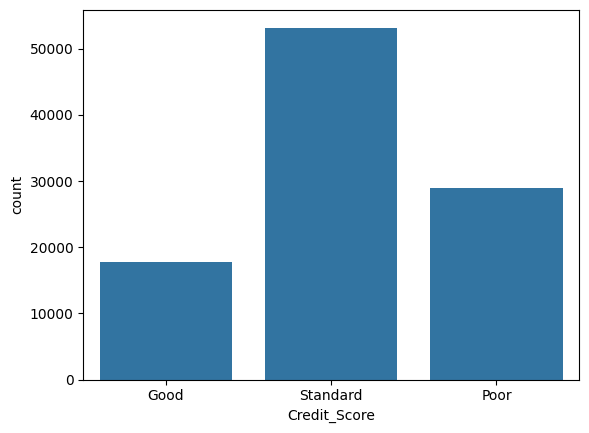

In [16]:
sns.countplot(preview_dataframe, x = 'Credit_Score')
plt.show()

### 02. Month

In [17]:
get_column_detail(preview_dataframe, 'Month')

****************************************

Details of column [Month]

Data Type: object

There is no null value

Number of Unique Values: 8

Distribution of column: 

Month
January     12500
February    12500
March       12500
April       12500
May         12500
June        12500
July        12500
August      12500
Name: count, dtype: int64

****************************************


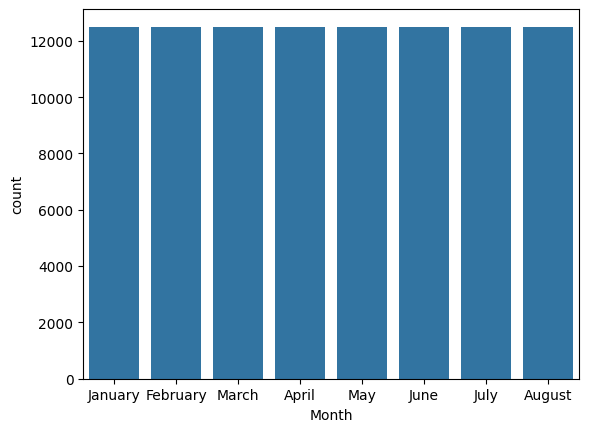

In [18]:
sns.countplot(preview_dataframe, x = 'Month')
plt.show()

****************************************
distribution plot of Month and Credit_Score


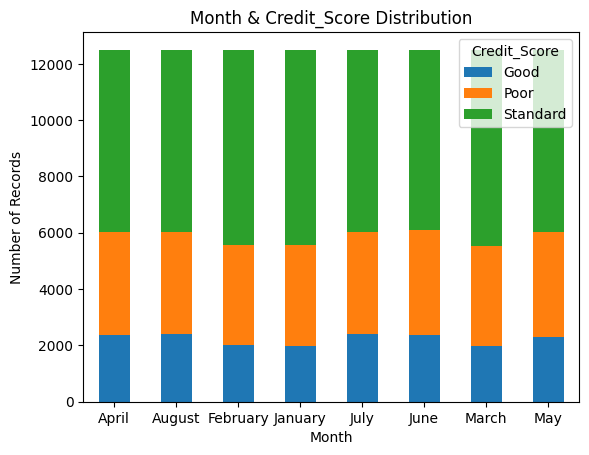

In [19]:
cross_plot(preview_dataframe, 'Month', Target_att)

### 03. Occupation

Findings:
*   value '______' needs to be replaced

In [20]:
get_column_detail(preview_dataframe, 'Occupation')

****************************************

Details of column [Occupation]

Data Type: object

There is no null value

Number of Unique Values: 16

Distribution of column: 

Occupation
_______          7062
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5911
Writer           5885
Name: count, dtype: int64

****************************************


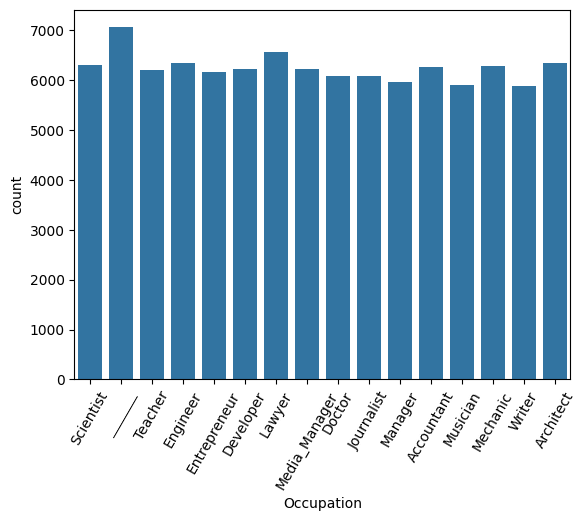

In [21]:
sns.countplot(preview_dataframe, x = 'Occupation')
plt.xticks(rotation = 60)
plt.show()

****************************************
distribution plot of Occupation and Credit_Score


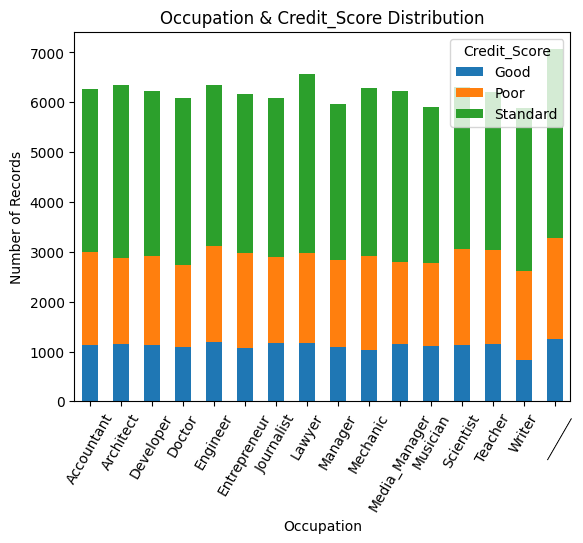

In [22]:
cross_plot(preview_dataframe, 'Occupation', Target_att, rotation = 60)

### 04. Type of Loan

Findings:
*   null values

In [23]:
get_column_detail(preview_dataframe, 'Type_of_Loan')

****************************************

Details of column [Type_of_Loan]

Data Type: object

There are 11408 null values

Number of Unique Values: 6260

Distribution of column: 

Type_of_Loan
NaN                                                                                                                                   11408
Not Specified                                                                                                                          1408
Credit-Builder Loan                                                                                                                    1280
Personal Loan                                                                                                                          1272
Debt Consolidation Loan                                                                                                                1264
                                                                                                          

### **05. Credit Mix**

Findings:
*   it seems higly correlated to "Credit score"
*   "-" needs to be replaced

In [24]:
get_column_detail(preview_dataframe, 'Credit_Mix')

****************************************

Details of column [Credit_Mix]

Data Type: object

There is no null value

Number of Unique Values: 4

Distribution of column: 

Credit_Mix
Standard    36479
Good        24337
_           20195
Bad         18989
Name: count, dtype: int64

****************************************


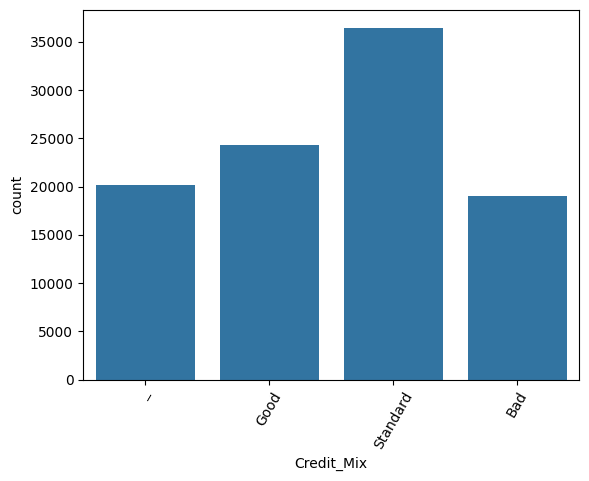

In [25]:
sns.countplot(preview_dataframe, x = 'Credit_Mix')
plt.xticks(rotation = 60)
plt.show()

****************************************
distribution plot of Credit_Mix and Credit_Score


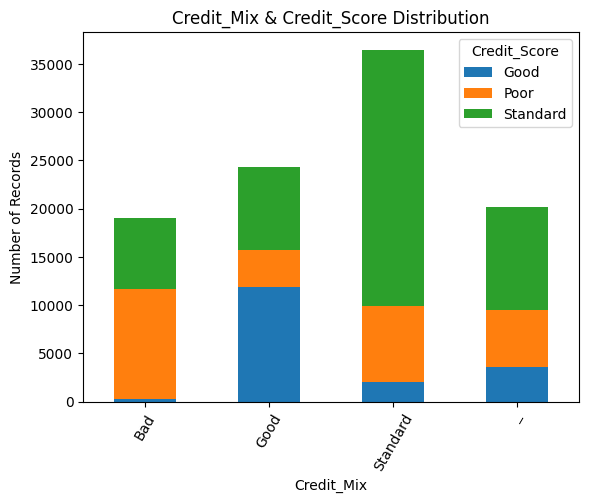

In [26]:
cross_plot(preview_dataframe, 'Credit_Mix', Target_att, rotation = 60)

### **06. Payment of Min amount**

Findings:
*   it seems higly correlated to "Credit score"

In [27]:
get_column_detail(preview_dataframe, 'Payment_of_Min_Amount')


****************************************

Details of column [Payment_of_Min_Amount]

Data Type: object

There is no null value

Number of Unique Values: 3

Distribution of column: 

Payment_of_Min_Amount
Yes    52326
No     35667
NM     12007
Name: count, dtype: int64

****************************************


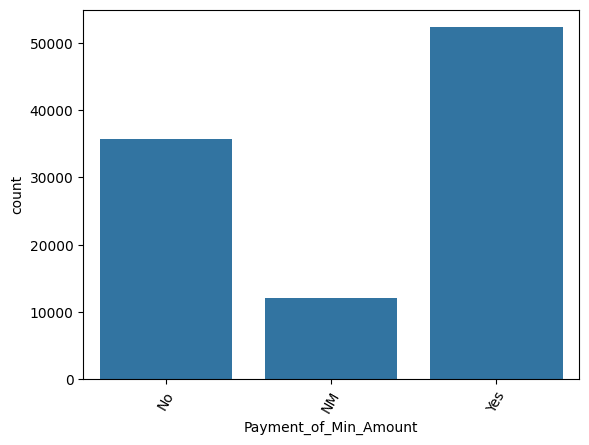

In [28]:
sns.countplot(preview_dataframe, x = 'Payment_of_Min_Amount')
plt.xticks(rotation = 60)
plt.show()

****************************************
distribution plot of Payment_of_Min_Amount and Credit_Score


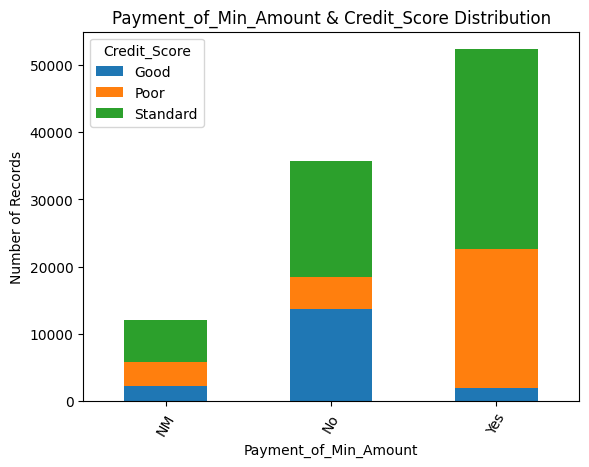

In [29]:
cross_plot(preview_dataframe, 'Payment_of_Min_Amount', Target_att, rotation = 60)

### 07. Payment Behaviour

Findings:
*   strange value: !@9#%8

In [30]:
get_column_detail(preview_dataframe, 'Payment_Behaviour')

****************************************

Details of column [Payment_Behaviour]

Data Type: object

There is no null value

Number of Unique Values: 7

Distribution of column: 

Payment_Behaviour
Low_spent_Small_value_payments      25513
High_spent_Medium_value_payments    17540
Low_spent_Medium_value_payments     13861
High_spent_Large_value_payments     13721
High_spent_Small_value_payments     11340
Low_spent_Large_value_payments      10425
!@9#%8                               7600
Name: count, dtype: int64

****************************************


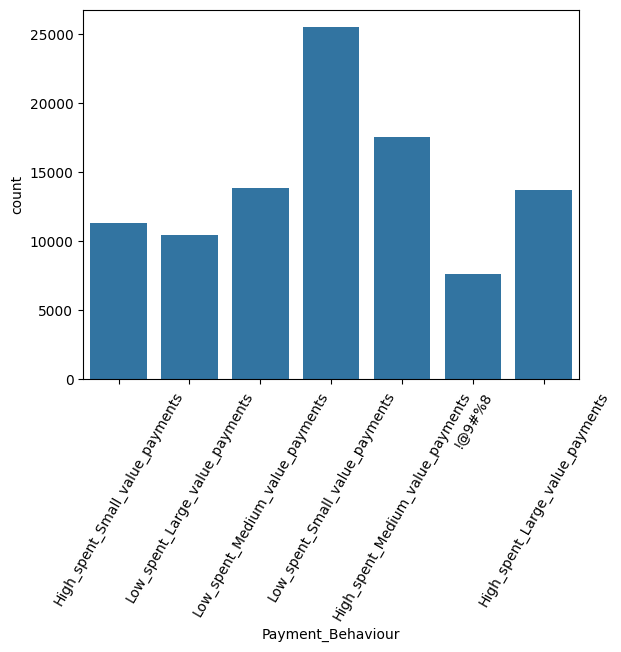

In [31]:
sns.countplot(preview_dataframe, x = 'Payment_Behaviour')
plt.xticks(rotation = 60)
plt.show()

****************************************
distribution plot of Payment_Behaviour and Credit_Score


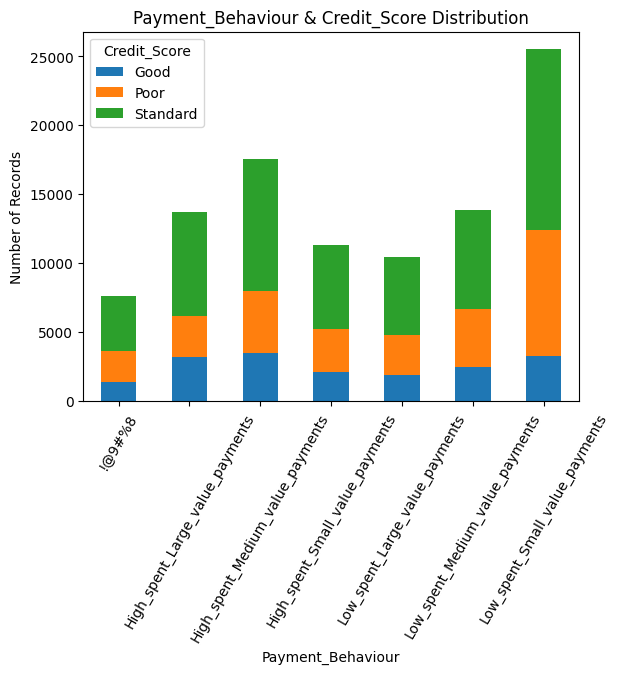

In [32]:
cross_plot(preview_dataframe, 'Payment_Behaviour', Target_att, rotation = 60)

## Getting into deeper details of each attributes - Numerical

### 01. Age

Findings:
*   age above 100 or below 0 should be replaced

In [33]:
get_column_detail(preview_dataframe, 'Age')

****************************************

Details of column [Age]

Data Type: object

There is no null value

Number of Unique Values: 1788

Distribution of column: 

Age
38      2833
28      2829
31      2806
26      2792
32      2749
        ... 
325        1
6611       1
3779       1
5751       1
3966       1
Name: count, Length: 1788, dtype: int64

****************************************


### 02. Annual Income

In [34]:
get_column_detail(preview_dataframe, 'Annual_Income')

****************************************

Details of column [Annual_Income]

Data Type: object

There is no null value

Number of Unique Values: 18940

Distribution of column: 

Annual_Income
20867.67      16
17273.83      16
36585.12      16
9141.63       15
33029.66      15
              ..
3874136.0      1
42588.14_      1
32291.88_      1
28730.26_      1
17770.795_     1
Name: count, Length: 18940, dtype: int64

****************************************


### 03. Monthly_Inhand_Salary

Findings:
*   null values

In [35]:
get_column_detail(preview_dataframe, 'Monthly_Inhand_Salary')

****************************************

Details of column [Monthly_Inhand_Salary]

Data Type: float64

There are 15002 null values

Number of Unique Values: 13235

Distribution of column: 

Monthly_Inhand_Salary
NaN            15002
6769.130000       15
2295.058333       15
6082.187500       15
6358.956667       15
               ...  
1698.145919        1
1515.410833        1
1465.444744        1
1879.396612        1
2760.869167        1
Name: count, Length: 13236, dtype: int64

****************************************


****************************************

Monthly_Inhand_Salary Distribution


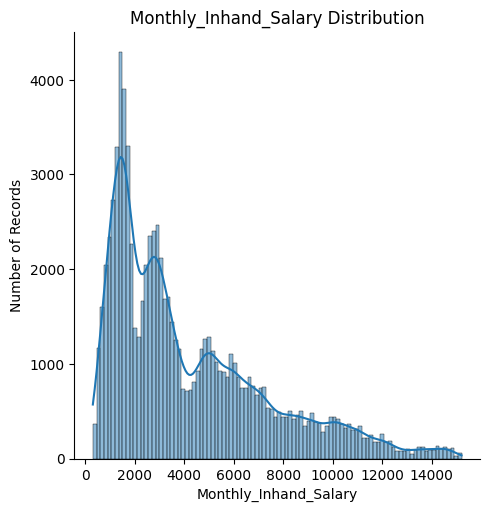

In [36]:
displot_plot(preview_dataframe, 'Monthly_Inhand_Salary', bins=100)

### 04. Num Bank Accounts

Findings:
*   outliers should be replaced

In [37]:
get_column_detail(preview_dataframe, 'Num_Bank_Accounts')

****************************************

Details of column [Num_Bank_Accounts]

Data Type: int64

There is no null value

Number of Unique Values: 943

Distribution of column: 

Num_Bank_Accounts
6       13001
7       12823
8       12765
4       12186
5       12118
        ...  
665         1
1388        1
1429        1
1588        1
1777        1
Name: count, Length: 943, dtype: int64

****************************************


****************************************

Num_Bank_Accounts Distribution


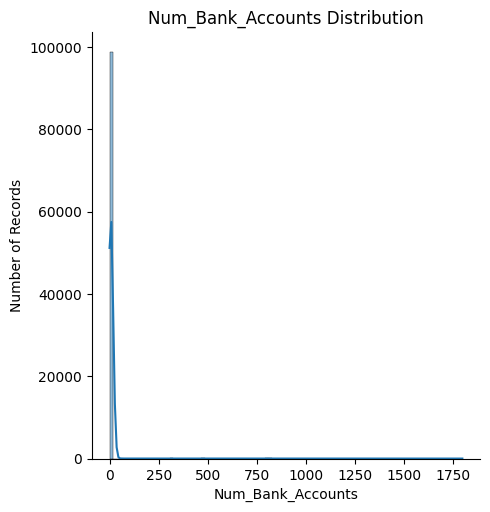

In [38]:
displot_plot(preview_dataframe, 'Num_Bank_Accounts', bins=100)

### 05. Num_Credit_Card

Findings:
*   outliers should be replaced

In [39]:
get_column_detail(preview_dataframe, 'Num_Credit_Card')

****************************************

Details of column [Num_Credit_Card]

Data Type: int64

There is no null value

Number of Unique Values: 1179

Distribution of column: 

Num_Credit_Card
5      18459
7      16615
6      16559
4      14030
3      13277
       ...  
551        1
426        1
784        1
673        1
599        1
Name: count, Length: 1179, dtype: int64

****************************************


****************************************

Num_Credit_Card Distribution


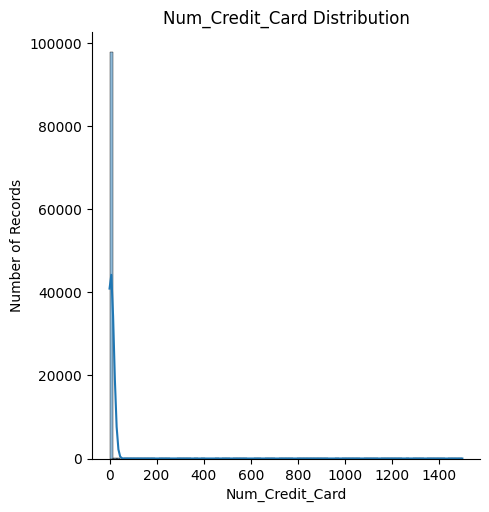

In [40]:
displot_plot(preview_dataframe, 'Num_Credit_Card', bins=100)

### 06. Interest_Rate

Findings:
*   outliers should be replaced

In [41]:
get_column_detail(preview_dataframe, 'Interest_Rate')

****************************************

Details of column [Interest_Rate]

Data Type: int64

There is no null value

Number of Unique Values: 1750

Distribution of column: 

Interest_Rate
8       5012
5       4979
6       4721
10      4540
12      4540
        ... 
3782       1
3849       1
2206       1
4828       1
1683       1
Name: count, Length: 1750, dtype: int64

****************************************


****************************************

Interest_Rate Distribution


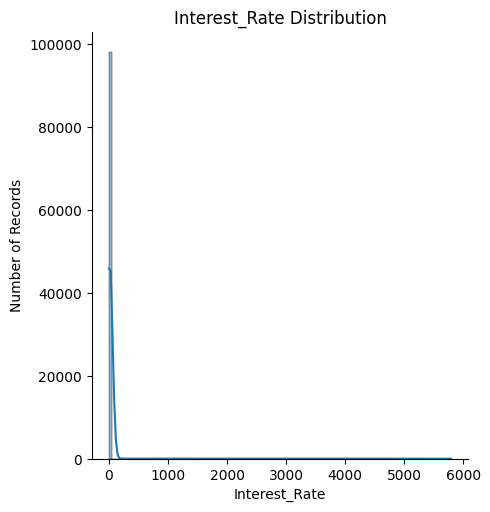

In [42]:
displot_plot(preview_dataframe, 'Interest_Rate', bins=100)

### 07. Delay_from_due_date

Findings:
*   outliers should be replaced

In [43]:
get_column_detail(preview_dataframe, 'Delay_from_due_date')

****************************************

Details of column [Delay_from_due_date]

Data Type: int64

There is no null value

Number of Unique Values: 73

Distribution of column: 

Delay_from_due_date
 15    3596
 13    3424
 8     3324
 14    3313
 10    3281
       ... 
-4       62
 65      56
-5       33
 66      32
 67      22
Name: count, Length: 73, dtype: int64

****************************************


****************************************

Delay_from_due_date Distribution


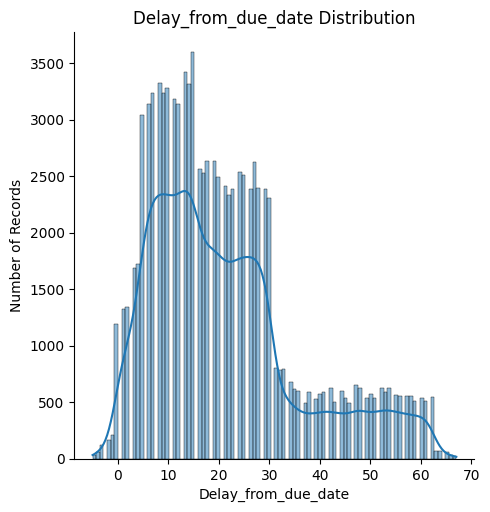

In [44]:
displot_plot(preview_dataframe, 'Delay_from_due_date', bins=100)

### 08. Num_Credit_Inquiries

Findings:
*   outlier should be replaced
*   null values

In [45]:
get_column_detail(preview_dataframe, 'Num_Credit_Inquiries')

****************************************

Details of column [Num_Credit_Inquiries]

Data Type: float64

There are 1965 null values

Number of Unique Values: 1223

Distribution of column: 

Num_Credit_Inquiries
4.0       11271
3.0        8890
6.0        8111
7.0        8058
2.0        8028
          ...  
719.0         1
2239.0        1
2001.0        1
1953.0        1
2473.0        1
Name: count, Length: 1224, dtype: int64

****************************************


****************************************

Num_Credit_Inquiries Distribution


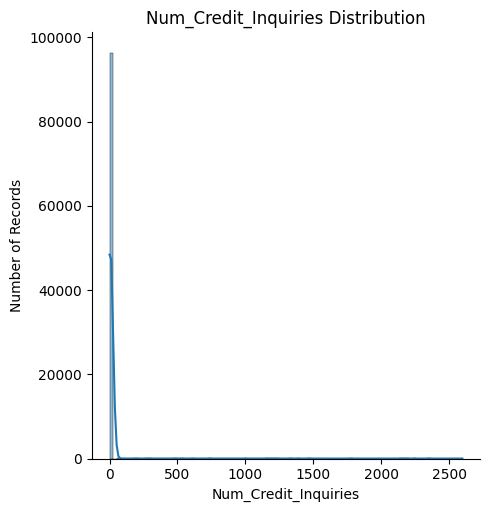

In [46]:
displot_plot(preview_dataframe, 'Num_Credit_Inquiries', bins=100)

### 09. Credit_Utilization_Ratio

In [47]:
get_column_detail(preview_dataframe, 'Credit_Utilization_Ratio')

****************************************

Details of column [Credit_Utilization_Ratio]

Data Type: float64

There is no null value

Number of Unique Values: 100000

Distribution of column: 

Credit_Utilization_Ratio
27.289440    1
33.494867    1
31.738359    1
30.625298    1
23.140640    1
            ..
31.377862    1
24.797347    1
27.262259    1
22.537593    1
23.933795    1
Name: count, Length: 100000, dtype: int64

****************************************


****************************************

Credit_Utilization_Ratio Distribution


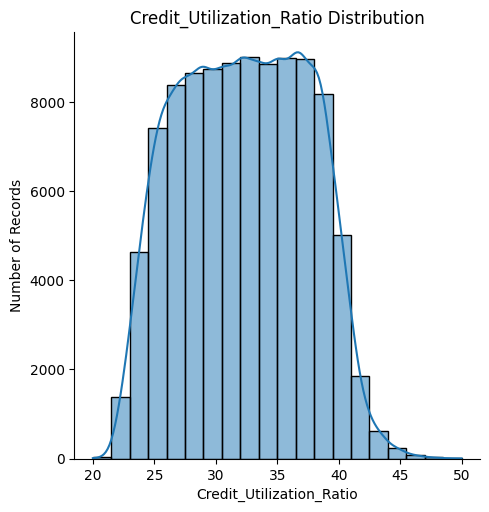

In [48]:
displot_plot(preview_dataframe, 'Credit_Utilization_Ratio')

### 10. Total_EMI_per_month

Findings:
*   outliers should be replaced

In [49]:
get_column_detail(preview_dataframe, 'Total_EMI_per_month')

****************************************

Details of column [Total_EMI_per_month]

Data Type: float64

There is no null value

Number of Unique Values: 14950

Distribution of column: 

Total_EMI_per_month
0.000000        10613
54.037058           8
30.230996           8
54.079318           8
45.341401           8
                ...  
61445.000000        1
73821.000000        1
55113.000000        1
61723.000000        1
31660.000000        1
Name: count, Length: 14950, dtype: int64

****************************************


****************************************

Total_EMI_per_month Distribution


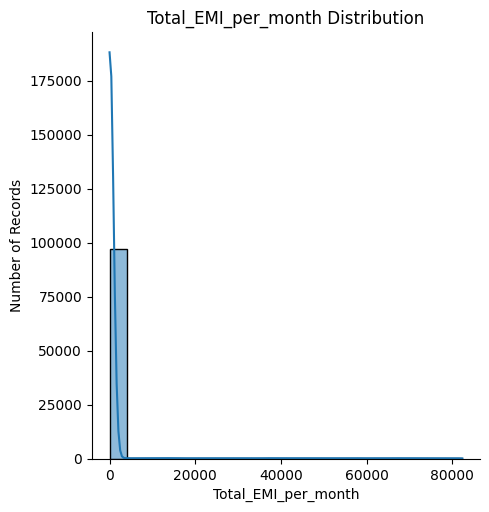

In [50]:
displot_plot(preview_dataframe, 'Total_EMI_per_month', rotation=0)

## Finding after going through each attributes in depth

1.   Need to replace outliers
2.   Need to replace strange values
3.   Need to replace null values
4.   Payment of Min amount and credit mix seems to be higly correlated to target
5.   Target Columns is Imbalanced

# 4. Data Pre-processing

## Read data from csv file into a spark dataframe

In [51]:
# Read the data into a spark dataframe
data = spark.read.csv("train.csv", header=True, inferSchema=True)

data.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- SSN: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Annual_Income: string (nullable = true)
 |-- Monthly_Inhand_Salary: double (nullable = true)
 |-- Num_Bank_Accounts: integer (nullable = true)
 |-- Num_Credit_Card: integer (nullable = true)
 |-- Interest_Rate: integer (nullable = true)
 |-- Num_of_Loan: string (nullable = true)
 |-- Type_of_Loan: string (nullable = true)
 |-- Delay_from_due_date: integer (nullable = true)
 |-- Num_of_Delayed_Payment: string (nullable = true)
 |-- Changed_Credit_Limit: string (nullable = true)
 |-- Num_Credit_Inquiries: double (nullable = true)
 |-- Credit_Mix: string (nullable = true)
 |-- Outstanding_Debt: string (nullable = true)
 |-- Credit_Utilization_Ratio: double (nullable = true)
 |-- Credit_History_Age: string (nullable = true

In [52]:
data.show(5)

+------+-----------+--------+-------------+----+-----------+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+------------------+------------+
|    ID|Customer_ID|   Month|         Name| Age|        SSN|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|   Monthly_Balance|Credit_Score|
+------+-----------+--------+-------------+----+-----------+------

## Pre-processing

In [53]:
# Function for reducing the outliers
def outlier_handling(df, median, target):
    id = df['Customer_ID']
    tar = df[target]
    if (abs(median[id] - tar) > 1):
        return median[id].astype(np.int64)
    else:
        return tar

In [54]:
# Copy the data into a new DataFrame to not corrupt the original data
df = data.drop("Name", "SSN")

### Change the data type of the columns

In [55]:
# In the ['Age', 'Annual Income'] column, if the value has underbar, replace the underbar with empty space
columns = ['Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment']
for column in columns:
    df = df.withColumn(column, F.regexp_replace(column, "_", ""))

In [56]:
# If there is a value ['nan', '_', '_______', '#F%$D@*&8', '!@9#%8', '__10000__'] in the whole data, replace it with null
for column in df.columns:
    df = df.withColumn(column, F.when(F.col(column).isin(['nan', '_', '_______', '#F%$D@*&8', '!@9#%8', '__10000__']), None).otherwise(F.col(column)))

In [57]:
# Convert the data type of the columns to numeric
to_numeric_columns = ['Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 'Changed_Credit_Limit', 'Amount_invested_monthly', 'Outstanding_Debt', 'Monthly_Balance']
for column in to_numeric_columns:
    # Can be int or float
    df = df.withColumn(column, df[column].cast("numeric"))

### Fill the missing values

In [58]:
# Fill the missing values with the mean, mode and first value matches to Customer_ID
fillna_with_mean = ['Monthly_Inhand_Salary', 'Num_Credit_Inquiries', 'Changed_Credit_Limit', 'Outstanding_Debt', 'Amount_invested_monthly', 'Monthly_Balance']
mean_window = Window.partitionBy('Customer_ID')
fillna_with_mode = ['Occupation', 'Payment_of_Min_Amount', 'Num_of_Delayed_Payment', 'Credit_Mix']
mode_window = Window.partitionBy('Customer_ID')
fillna_with_first = ['Age', 'Type_of_Loan']

for column in fillna_with_mean:
    df = df.withColumn(column, F.when(F.col(column).isNull(), F.avg(column).over(mean_window)).otherwise(F.col(column)))

for column in fillna_with_mode:
    mode_val = df.groupBy('Customer_ID', column).count().orderBy(F.desc('count')).select(column).limit(1).collect()[0][0]
    df = df.withColumn(column, F.when(F.col(column).isNull(), mode_val).otherwise(F.col(column)))

for column in fillna_with_first:
    first_window = Window.partitionBy('Customer_ID').orderBy(column)
    df = df.withColumn(column, F.when(F.col(column).isNull(), F.first(column).over(first_window)).otherwise(F.col(column)))

df = df.fillna('Not Specified', subset=['Type_of_Loan', 'Payment_Behaviour'])
df = df.withColumn('Age', df['Age'].cast("int"))

In [59]:
# Check null counts
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Show column counts and data types
df.select([F.count(F.col(c)).alias(c) for c in df.columns]).show()
df.printSchema()

+---+-----------+-----+---+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+------------------+---------------------+-------------------+-----------------------+-----------------+---------------+------------+
| ID|Customer_ID|Month|Age|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|Payment_Behaviour|Monthly_Balance|Credit_Score|
+---+-----------+-----+---+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+------------+-----------------

+------+-----------+------+------+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+------------------+---------------------+-------------------+-----------------------+-----------------+---------------+------------+
|    ID|Customer_ID| Month|   Age|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|Payment_Behaviour|Monthly_Balance|Credit_Score|
+------+-----------+------+------+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+---------

### Reduce the outliers

In [60]:
# Reduce outliers from the data, and replace them with the median
outlier_columns_int = ['Age', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate',\
                       'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment']
outlier_columns_float = ['Annual_Income', 'Num_Credit_Inquiries', 'Outstanding_Debt',\
                    'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance']

# Convert spark dataframe to pandas dataframe
df = df.toPandas()

for i in range(len(outlier_columns_int)):
    df[outlier_columns_int[i]] = df[outlier_columns_int[i]].astype(np.int64)  # Convert 'decimal.Decimal' to 'float'
    median = df.groupby('Customer_ID')[outlier_columns_int[i]].median()
    df[outlier_columns_int[i]] = df.apply(lambda row: outlier_handling(row, median, outlier_columns_int[i]), axis=1)

for i in range(len(outlier_columns_float)):
    df[outlier_columns_float[i]] = df[outlier_columns_float[i]].astype(np.float64)  # Convert 'decimal.Decimal' to 'float'
    median = df.groupby('Customer_ID')[outlier_columns_float[i]].median()
    df[outlier_columns_float[i]] = df.apply(lambda row: outlier_handling(row, median, outlier_columns_float[i]), axis=1)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Age                       100000 non-null  int64  
 4   Occupation                100000 non-null  object 
 5   Annual_Income             100000 non-null  float64
 6   Monthly_Inhand_Salary     100000 non-null  float64
 7   Num_Bank_Accounts         100000 non-null  int64  
 8   Num_Credit_Card           100000 non-null  int64  
 9   Interest_Rate             100000 non-null  int64  
 10  Num_of_Loan               100000 non-null  int64  
 11  Type_of_Loan              100000 non-null  object 
 12  Delay_from_due_date       100000 non-null  int64  
 13  Num_of_Delayed_Payment    100000 non-null  in

### Change the categorical data to numerical data

In [61]:
df['Month'] = pd.to_datetime(df['Month'], format="%B").dt.month.astype(np.int64)

# Converting Credit History Age into months
# Extract years and months using regular expressions
df['Years'] = df['Credit_History_Age'].str.extract('(\d+) Years', expand=False).astype(float)
df['Months'] = df['Credit_History_Age'].str.extract('(\d+) Months', expand=False).astype(float)

# Calculate the total duration in months
df['Credit_History_Age'] = df['Years'] * 12 + df['Months']
df['Credit_History_Age'] = df.groupby('Customer_ID')['Credit_History_Age'].transform(lambda x: x.interpolate(method='index', limit_direction='both') if x.count() > 1 else x)

# Converting ordinal data ['Credit_Mix','Credit_Score']
customScoreMapping = {'Good': 2.0, 'Standard': 1.0, 'Poor': 0.0}
df['Credit_Score_index'] = df['Credit_Score'].map(customScoreMapping)

customMixMapping = {'Good': 2.0, 'Standard': 1.0, 'Bad': 0.0}
df['Credit_Mix_index'] = df['Credit_Mix'].map(customMixMapping)

df.drop(['ID','Customer_ID','Type_of_Loan'], axis=1, inplace=True)
df.drop(['Years','Months'], axis=1 ,inplace=True)

# Convert it back to spark dataframe
df = spark.createDataFrame(df)

# Convert the categorical columns to numerical columns
# Occupation, Credit_Mix, Payment_of_Min_Amount, Payment_Behaviour, Credit_Score
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in ['Occupation', 'Payment_of_Min_Amount', 'Payment_Behaviour']]
pipeline = Pipeline(stages=indexers)
df = pipeline.fit(df).transform(df)
df.printSchema()

# Convert it back to pandas dataframe
df = df.toPandas()

df.drop(['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour', 'Credit_Score'], axis=1, inplace=True)

df.info()
df.head()

root
 |-- Month: long (nullable = true)
 |-- Age: long (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Annual_Income: double (nullable = true)
 |-- Monthly_Inhand_Salary: double (nullable = true)
 |-- Num_Bank_Accounts: long (nullable = true)
 |-- Num_Credit_Card: long (nullable = true)
 |-- Interest_Rate: long (nullable = true)
 |-- Num_of_Loan: long (nullable = true)
 |-- Delay_from_due_date: long (nullable = true)
 |-- Num_of_Delayed_Payment: long (nullable = true)
 |-- Changed_Credit_Limit: decimal(38,18) (nullable = true)
 |-- Num_Credit_Inquiries: double (nullable = true)
 |-- Credit_Mix: string (nullable = true)
 |-- Outstanding_Debt: double (nullable = true)
 |-- Credit_Utilization_Ratio: double (nullable = true)
 |-- Credit_History_Age: double (nullable = true)
 |-- Payment_of_Min_Amount: string (nullable = true)
 |-- Total_EMI_per_month: double (nullable = true)
 |-- Amount_invested_monthly: double (nullable = true)
 |-- Payment_Behaviour: string (nullable = 

,Month,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_Score_index,Credit_Mix_index,Occupation_index,Payment_of_Min_Amount_index,Payment_Behaviour_index
0,1,18,113781.0,9549.7825,1,4,1,0,14,7,...,37.998760,183.0,0.0,505.0000,824.0,0.0,2.0,8.0,1.0,2.0
1,2,18,113781.0,9549.7825,1,4,1,0,14,7,...,35.947655,184.0,0.0,505.0000,824.0,0.0,0.0,8.0,1.0,5.0
2,3,18,113781.0,9549.7825,1,4,1,0,14,7,...,43.829630,185.0,0.0,505.3333,824.0,0.0,2.0,8.0,1.0,3.0
3,4,18,113781.0,9549.7825,1,4,1,0,14,7,...,31.016086,186.0,0.0,505.3333,824.0,1.0,2.0,8.0,1.0,3.0
4,5,19,113781.0,9549.7825,1,4,1,0,14,7,...,32.035662,187.0,0.0,505.0000,824.0,0.0,2.0,8.0,1.0,0.0


### Diagrams after preprocessing  (to check if all issues are resolved)

array([[<Axes: title={'center': 'Month'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Annual_Income'}>,
        <Axes: title={'center': 'Monthly_Inhand_Salary'}>,
        <Axes: title={'center': 'Num_Bank_Accounts'}>],
       [<Axes: title={'center': 'Num_Credit_Card'}>,
        <Axes: title={'center': 'Interest_Rate'}>,
        <Axes: title={'center': 'Num_of_Loan'}>,
        <Axes: title={'center': 'Delay_from_due_date'}>,
        <Axes: title={'center': 'Num_of_Delayed_Payment'}>],
       [<Axes: title={'center': 'Num_Credit_Inquiries'}>,
        <Axes: title={'center': 'Outstanding_Debt'}>,
        <Axes: title={'center': 'Credit_Utilization_Ratio'}>,
        <Axes: title={'center': 'Credit_History_Age'}>,
        <Axes: title={'center': 'Total_EMI_per_month'}>],
       [<Axes: title={'center': 'Amount_invested_monthly'}>,
        <Axes: title={'center': 'Monthly_Balance'}>,
        <Axes: title={'center': 'Credit_Score_index'}>,
        <Axes: title=

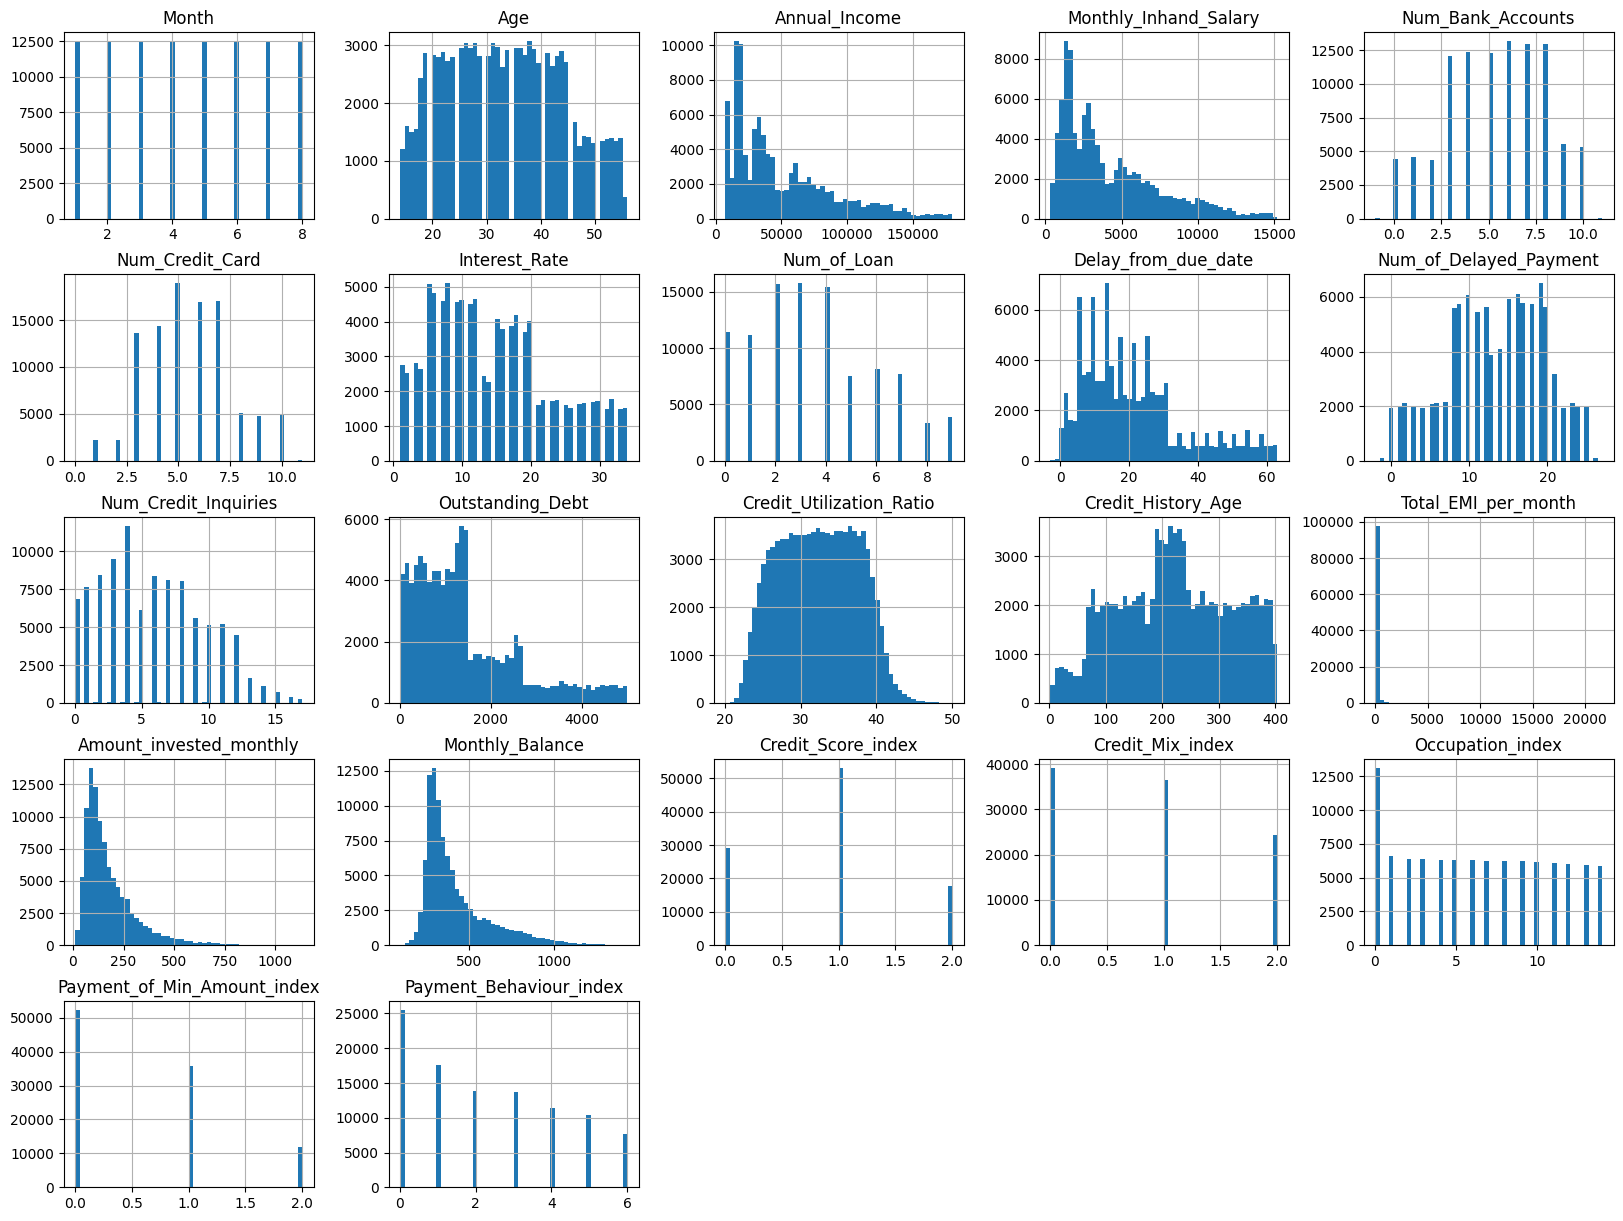

In [62]:
df.hist(bins=50, figsize=(20,15))

**Removing strange values**

Before

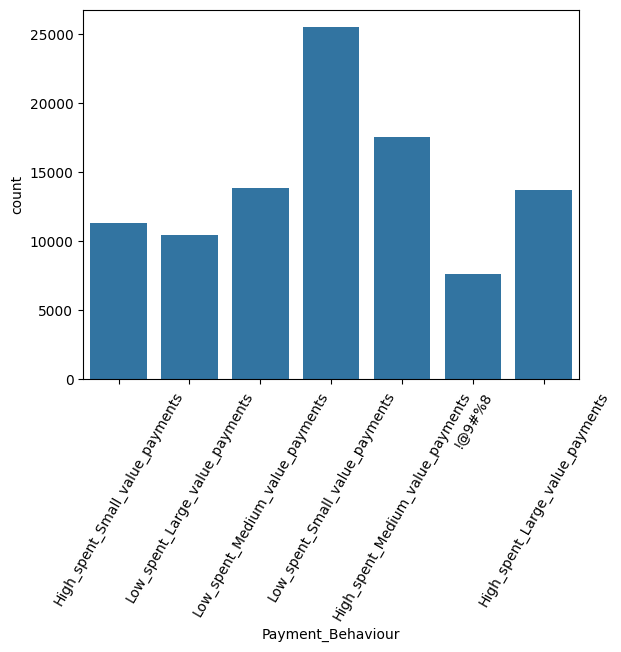

In [63]:
sns.countplot(preview_dataframe, x = 'Payment_Behaviour')
plt.xticks(rotation = 60)
plt.show()

After

<Axes: xlabel='Payment_Behaviour_index', ylabel='count'>

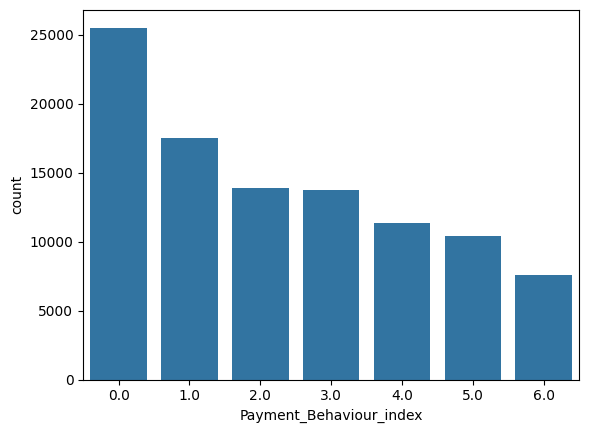

In [64]:
sns.countplot(df, x = 'Payment_Behaviour_index')

**handling outliers - 1**

Before

****************************************

Num_Bank_Accounts Distribution


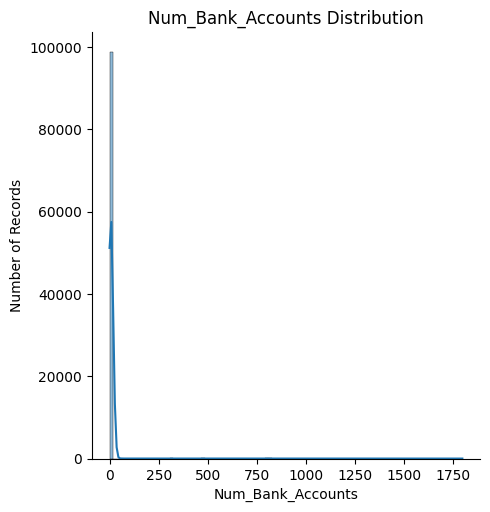

In [65]:
displot_plot(preview_dataframe, 'Num_Bank_Accounts', bins=100)

After

<Axes: xlabel='Num_Bank_Accounts', ylabel='count'>

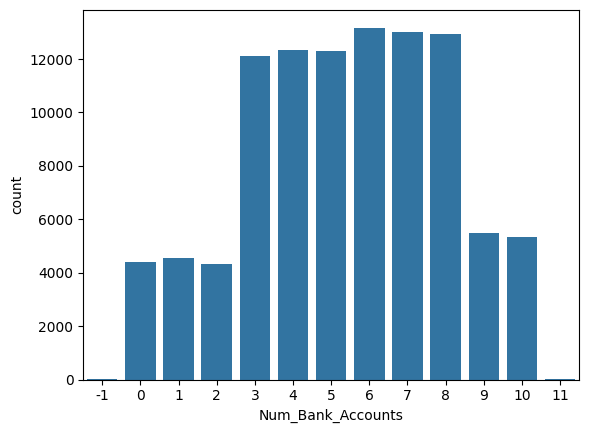

In [66]:
sns.countplot(df, x = 'Num_Bank_Accounts')

**handling outliers - 2**

Before

****************************************

Num_Credit_Card Distribution


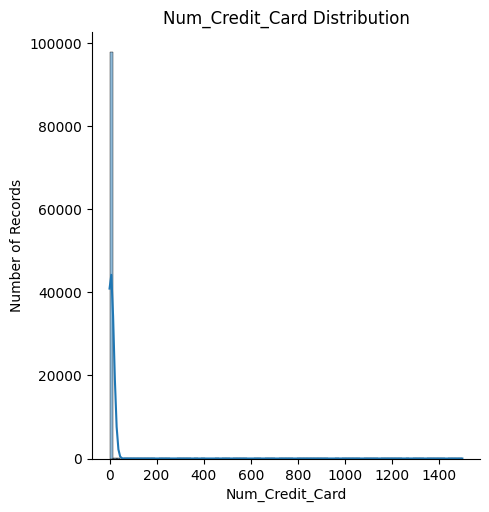

In [67]:
displot_plot(preview_dataframe, 'Num_Credit_Card', bins=100)

After

<Axes: xlabel='Num_Credit_Card', ylabel='count'>

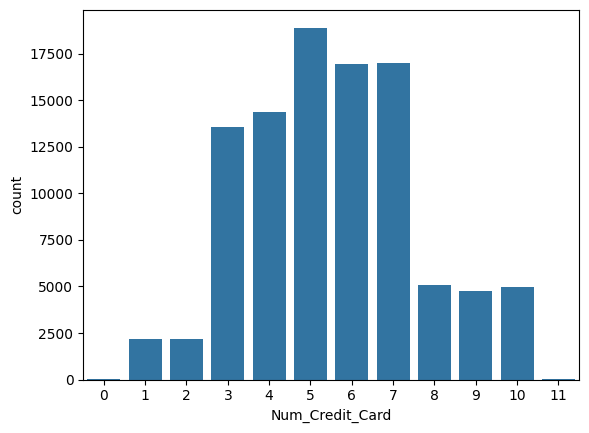

In [68]:
sns.countplot(df, x = 'Num_Credit_Card')

### Visualize the data correlation

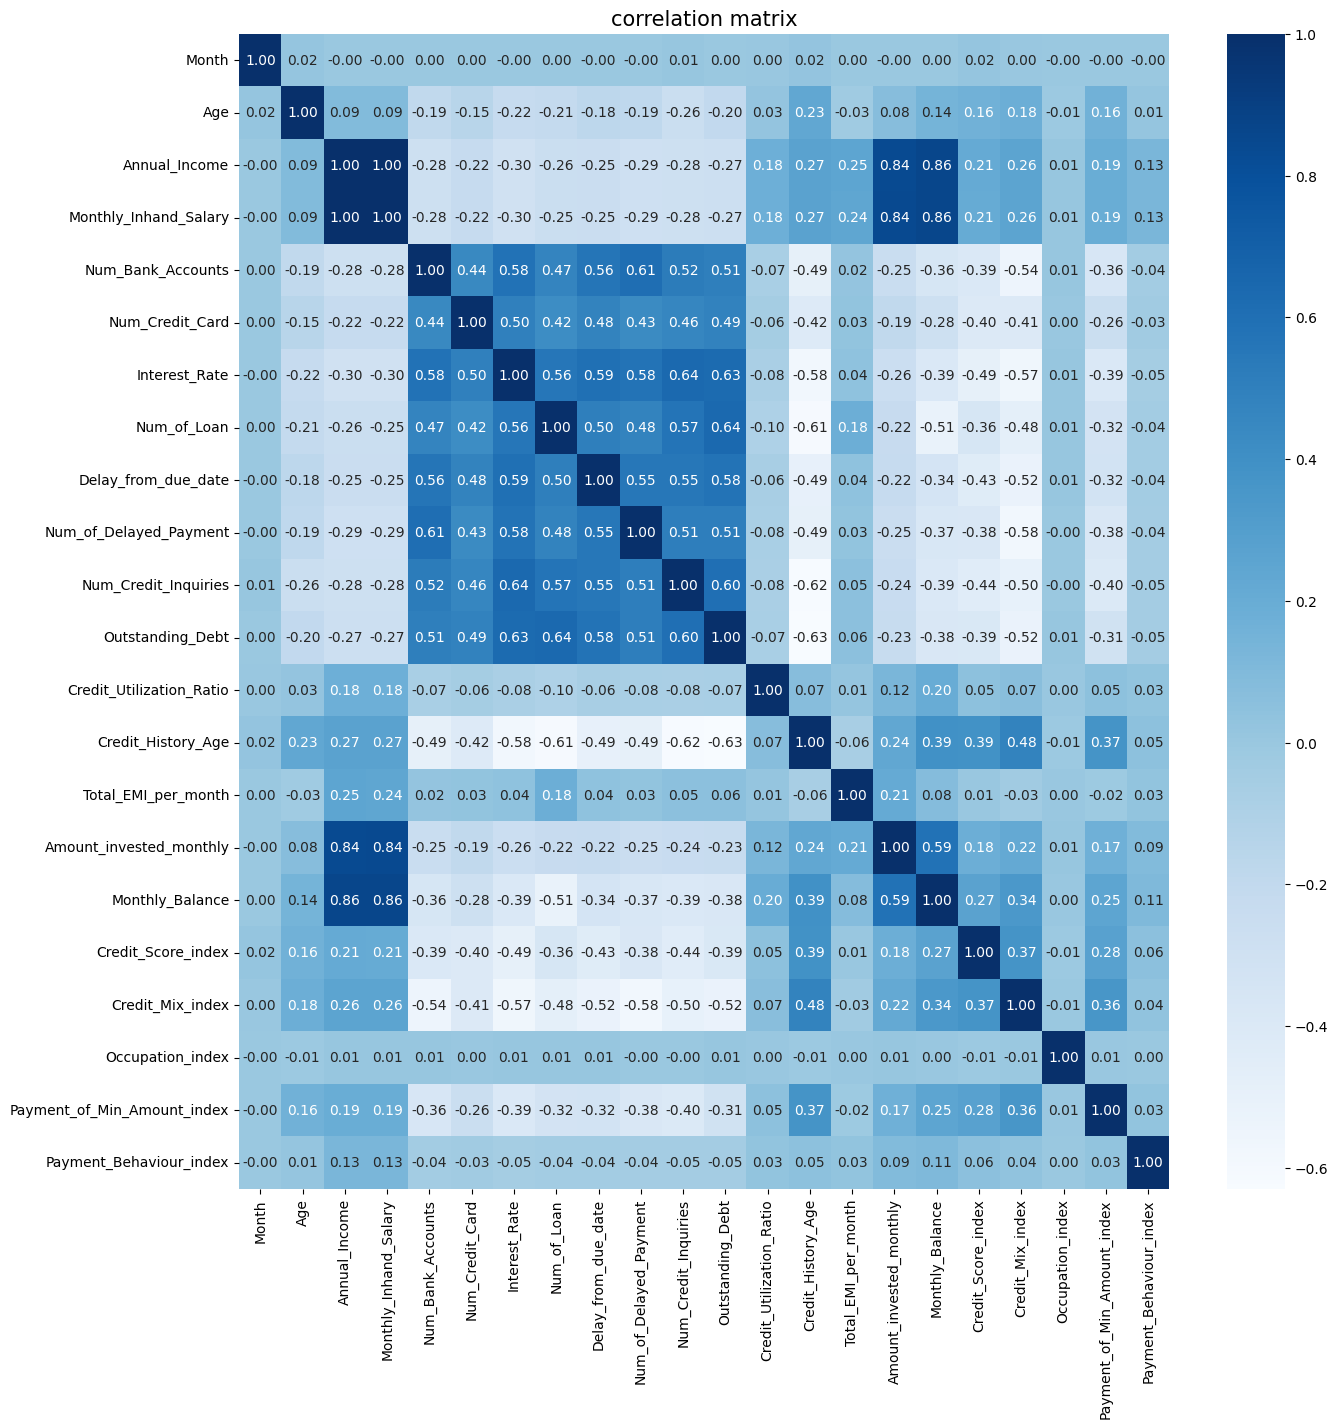

In [69]:
df_corr=df.select_dtypes(include=["float64","int64"]).corr()

plt.figure(figsize=(15,15))
plt.title("correlation matrix",fontsize=15)
sns.heatmap(df_corr, annot=True, cmap="Blues", fmt=".2f")
plt.show()

In [70]:
# Drop the unnecessary columns (has same correlation with other columns)
df.drop('Monthly_Inhand_Salary', axis=1, inplace=True)

Text(0.5, 1.0, 'Correlation between Credit_Score and other features\n<Before Resampling>')

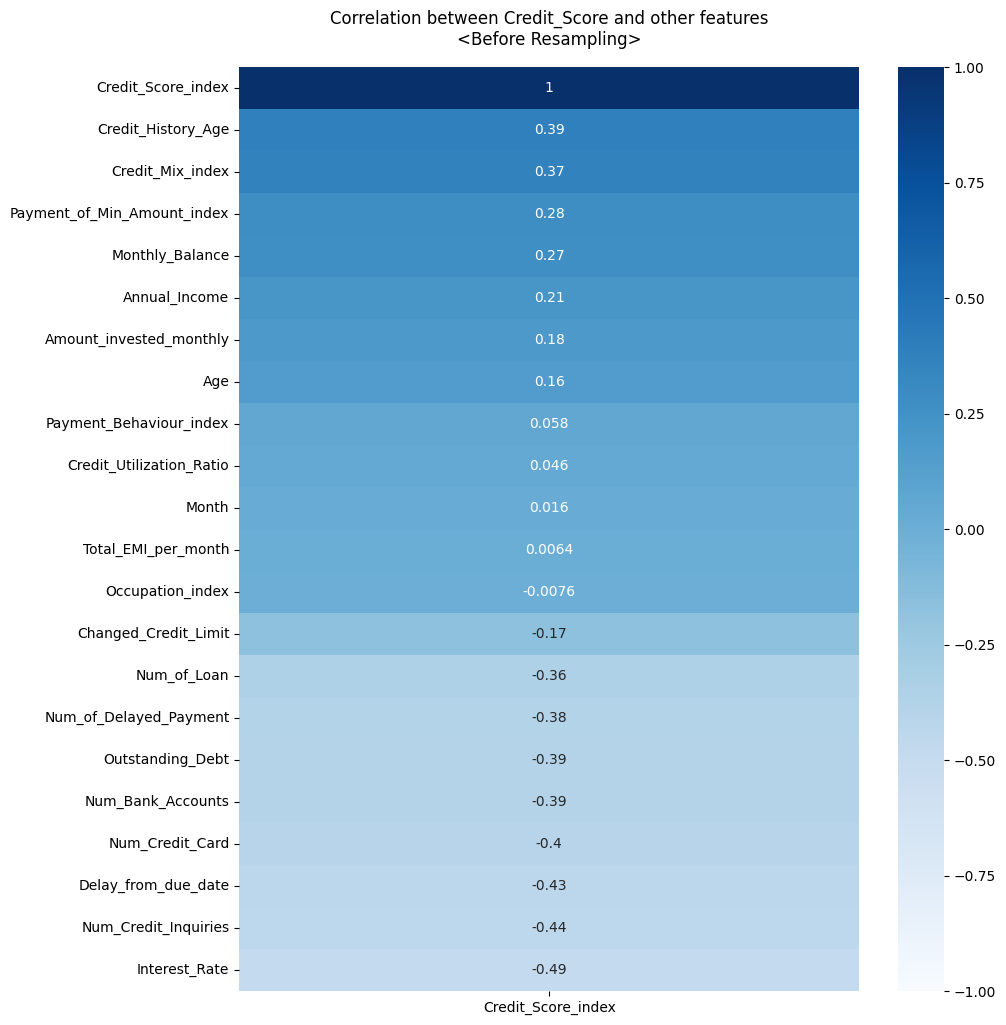

In [71]:
plt.figure(figsize=(10,12))
heatmap = sns.heatmap(df.corr()[['Credit_Score_index']].sort_values(by='Credit_Score_index', ascending=False), vmin=-1, vmax=1, annot=True, cmap='Blues')
heatmap.set_title('Correlation between Credit_Score and other features\n<Before Resampling>', fontdict={'fontsize':12}, pad=16)

Text(0.5, 1.0, 'Num_Credit_Inquiries  vs Credit Score')

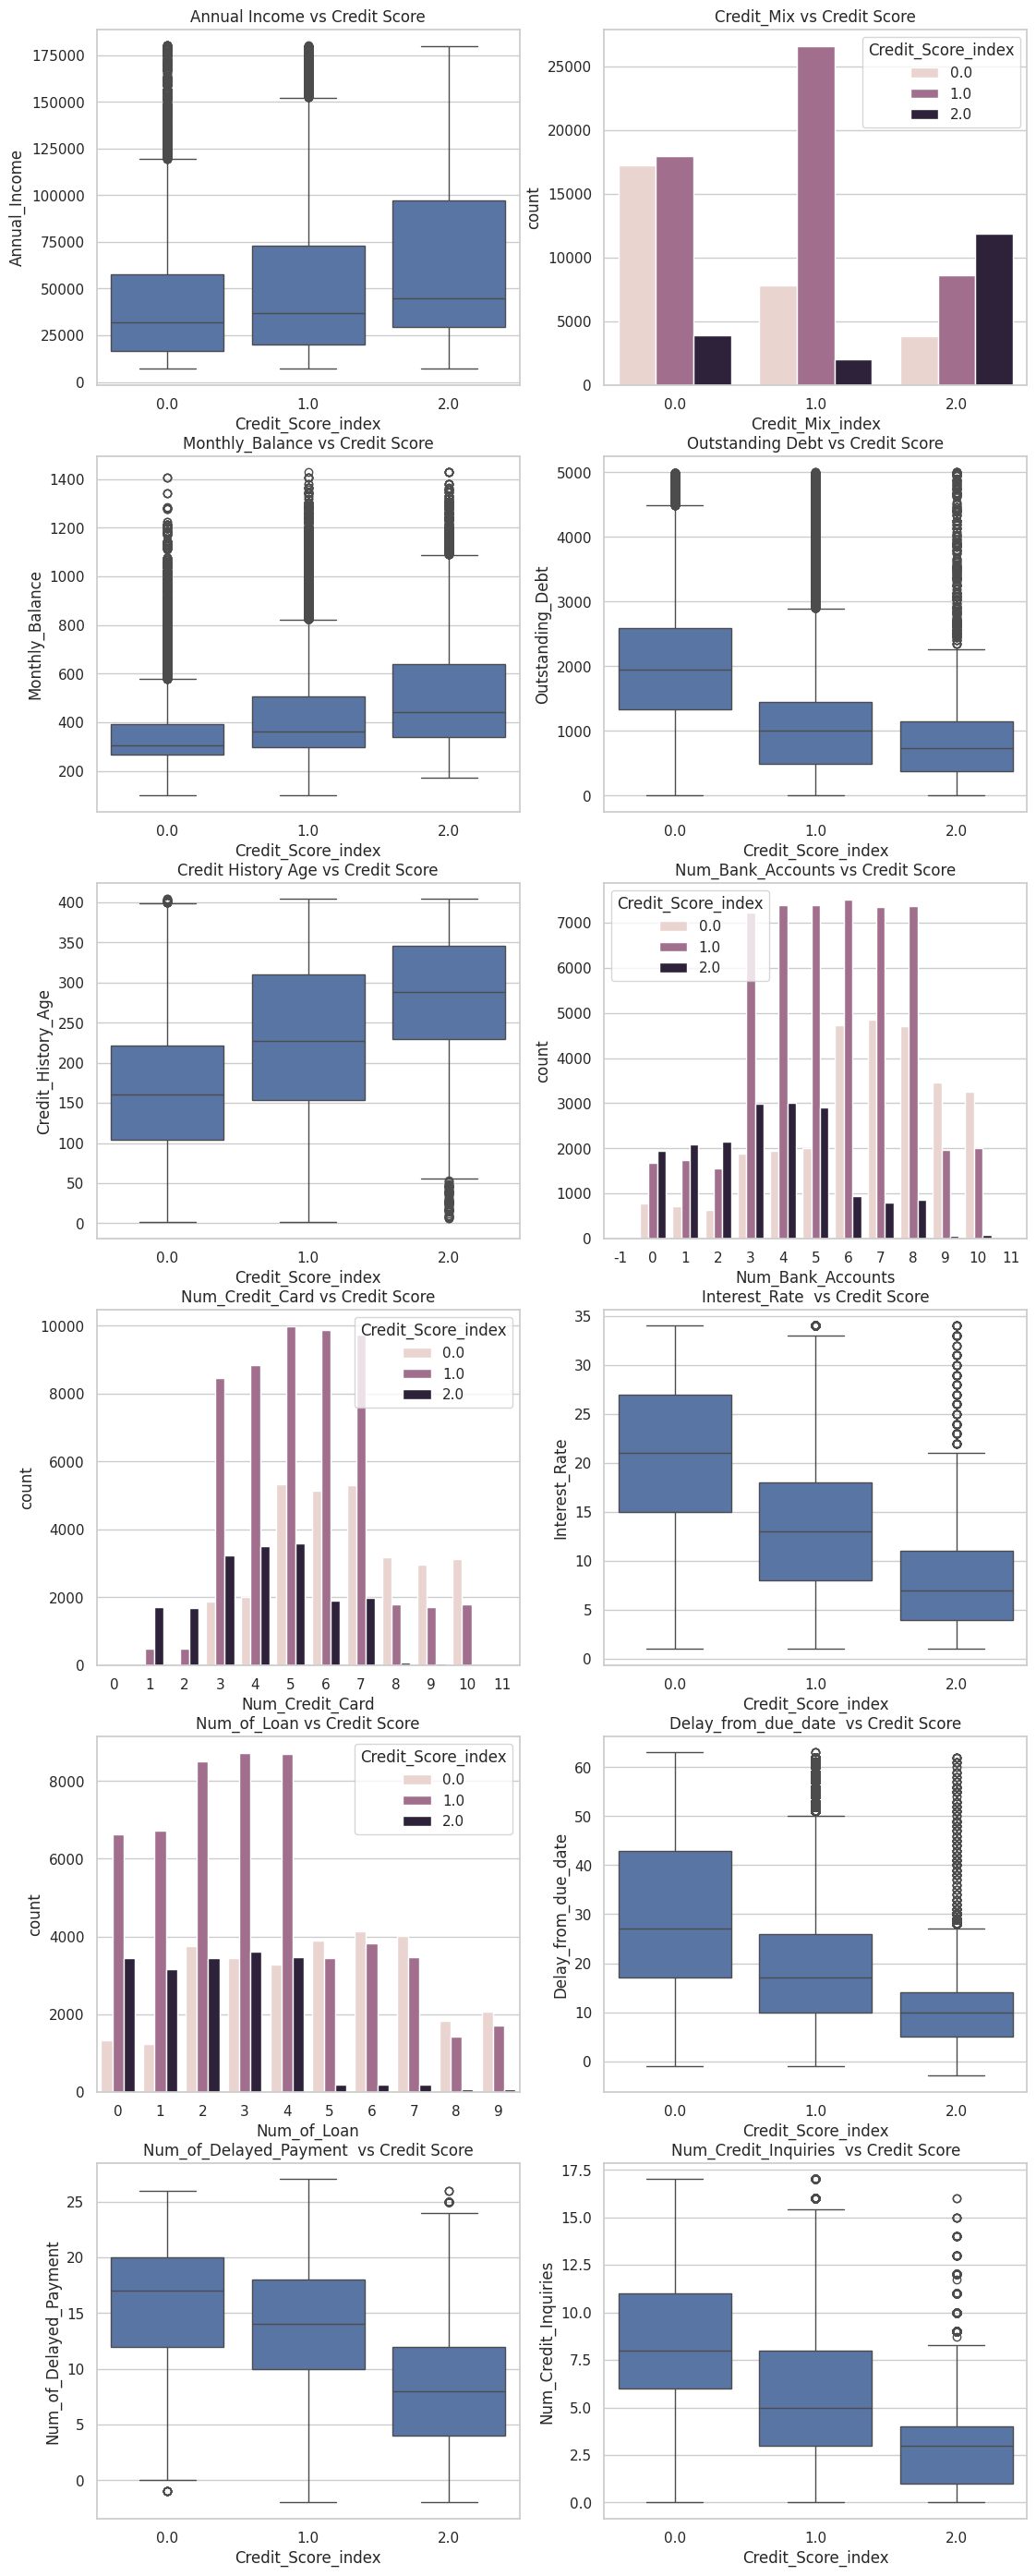

In [72]:
# Create subplots for each feature
# Set the style of the plots
sns.set(style="whitegrid")
# Create subplots for each feature
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(13, 35))

# Here we use the unencoded dataframe for clarity purposes 
# Categorical/Discrete data against credit score

sns.countplot(hue='Credit_Score_index', x='Num_Bank_Accounts', data=df, ax=axes[2, 1])
axes[2, 1].set_title("Num_Bank_Accounts vs Credit Score")

sns.countplot(hue='Credit_Score_index', x='Num_Credit_Card', data=df, ax=axes[3, 0])
axes[3, 0].set_title("Num_Credit_Card vs Credit Score")

sns.countplot(hue='Credit_Score_index', x='Num_of_Loan', data=df, ax=axes[4, 0])
axes[4, 0].set_title("Num_of_Loan vs Credit Score")

sns.countplot(hue='Credit_Score_index', x='Credit_Mix_index', data=df, ax=axes[0, 1])
axes[0, 1].set_title("Credit_Mix vs Credit Score")


# Continuous data agaisnt credt score 
sns.boxplot(x='Credit_Score_index', y='Annual_Income', data=df, ax=axes[0, 0])
axes[0, 0].set_title("Annual Income vs Credit Score")

sns.boxplot(x='Credit_Score_index', y='Monthly_Balance', data=df, ax=axes[1, 0])
axes[1, 0].set_title("Monthly_Balance vs Credit Score")

sns.boxplot(x='Credit_Score_index', y='Outstanding_Debt', data=df, ax=axes[1, 1])
axes[1, 1].set_title("Outstanding Debt vs Credit Score")

sns.boxplot(x='Credit_Score_index', y='Credit_History_Age', data=df, ax=axes[2, 0])
axes[2, 0].set_title("Credit History Age vs Credit Score")

sns.boxplot(x='Credit_Score_index', y='Interest_Rate', data=df, ax=axes[3, 1])
axes[3, 1].set_title("Interest_Rate  vs Credit Score")

sns.boxplot(x='Credit_Score_index', y='Delay_from_due_date', data=df, ax=axes[4, 1])
axes[4, 1].set_title("Delay_from_due_date  vs Credit Score")

sns.boxplot(x='Credit_Score_index', y='Num_of_Delayed_Payment', data=df, ax=axes[5, 0])
axes[5, 0].set_title("Num_of_Delayed_Payment  vs Credit Score")

sns.boxplot(x='Credit_Score_index', y='Num_Credit_Inquiries', data=df, ax=axes[5, 1])
axes[5, 1].set_title("Num_Credit_Inquiries  vs Credit Score")

## Convert the data back to spark dataframe

In [73]:
# Convert it back to spark dataframe
df = spark.createDataFrame(df)
df.printSchema()

root
 |-- Month: long (nullable = true)
 |-- Age: long (nullable = true)
 |-- Annual_Income: double (nullable = true)
 |-- Num_Bank_Accounts: long (nullable = true)
 |-- Num_Credit_Card: long (nullable = true)
 |-- Interest_Rate: long (nullable = true)
 |-- Num_of_Loan: long (nullable = true)
 |-- Delay_from_due_date: long (nullable = true)
 |-- Num_of_Delayed_Payment: long (nullable = true)
 |-- Changed_Credit_Limit: decimal(38,18) (nullable = true)
 |-- Num_Credit_Inquiries: double (nullable = true)
 |-- Outstanding_Debt: double (nullable = true)
 |-- Credit_Utilization_Ratio: double (nullable = true)
 |-- Credit_History_Age: double (nullable = true)
 |-- Total_EMI_per_month: double (nullable = true)
 |-- Amount_invested_monthly: double (nullable = true)
 |-- Monthly_Balance: double (nullable = true)
 |-- Credit_Score_index: double (nullable = true)
 |-- Credit_Mix_index: double (nullable = true)
 |-- Occupation_index: double (nullable = true)
 |-- Payment_of_Min_Amount_index: double

## Combine all the features into a single vector

In [74]:
# Create a list of input columns excluding the categorical columns
input_cols = [col for col in df.columns if col not in
              ['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour', 'Credit_Score', 'Credit_Score_index']]

# Create a VectorAssembler to combine the selected input columns into a single "features" column
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
# Transform the train and test DataFrames to include the "features" column
df = assembler.transform(df)
print(df.count())
df.show(5)
inputLength = len(assembler.getInputCols())
print(inputLength)

100000
+-----+---+-------------+-----------------+---------------+-------------+-----------+-------------------+----------------------+--------------------+--------------------+----------------+------------------------+------------------+-------------------+-----------------------+---------------+------------------+----------------+----------------+---------------------------+-----------------------+--------------------+
|Month|Age|Annual_Income|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Outstanding_Debt|Credit_Utilization_Ratio|Credit_History_Age|Total_EMI_per_month|Amount_invested_monthly|Monthly_Balance|Credit_Score_index|Credit_Mix_index|Occupation_index|Payment_of_Min_Amount_index|Payment_Behaviour_index|            features|
+-----+---+-------------+-----------------+---------------+-------------+-----------+-------------------+----------------------+--------------------+--------

## Data Oversampling with Spark

In [75]:
# Split the DataFrame into minority and majority classes
class_0 = df.filter("Credit_Score_index = 0.0")
class_1 = df.filter("Credit_Score_index = 1.0")
class_2 = df.filter("Credit_Score_index = 2.0")

class_0_ratio = class_1.count() / class_0.count()
class_2_ratio = class_1.count() / class_2.count()

print(class_0.count(), class_1.count(), class_2.count())

# Oversample each minority class
oversampled_class_0 = class_0.sample(True, class_0_ratio, seed=42)
oversampled_class_2 = class_2.sample(True, class_2_ratio, seed=42)

# Combine oversampled minority classes with majority class
df_resampled = class_1.union(oversampled_class_0)
df_resampled = df_resampled.union(oversampled_class_2)

# Show the oversampled DataFrame
df_resampled.show(5)
df_resampled.groupBy('Credit_Score_index').count().show()

28998 53174 17828
+-----+---+-------------+-----------------+---------------+-------------+-----------+-------------------+----------------------+--------------------+--------------------+----------------+------------------------+------------------+-------------------+-----------------------+---------------+------------------+----------------+----------------+---------------------------+-----------------------+--------------------+
|Month|Age|Annual_Income|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Outstanding_Debt|Credit_Utilization_Ratio|Credit_History_Age|Total_EMI_per_month|Amount_invested_monthly|Monthly_Balance|Credit_Score_index|Credit_Mix_index|Occupation_index|Payment_of_Min_Amount_index|Payment_Behaviour_index|            features|
+-----+---+-------------+-----------------+---------------+-------------+-----------+-------------------+----------------------+------------------

**So, we handled**

1.   Replace outliers   ✓
2.   Replace strange values  ✓
3.   Replace null values  ✓
4.   Target Columns is now balanced ✓

Text(0.5, 1.0, 'Correlation between Credit_Score and other features\n<After Resampling>')

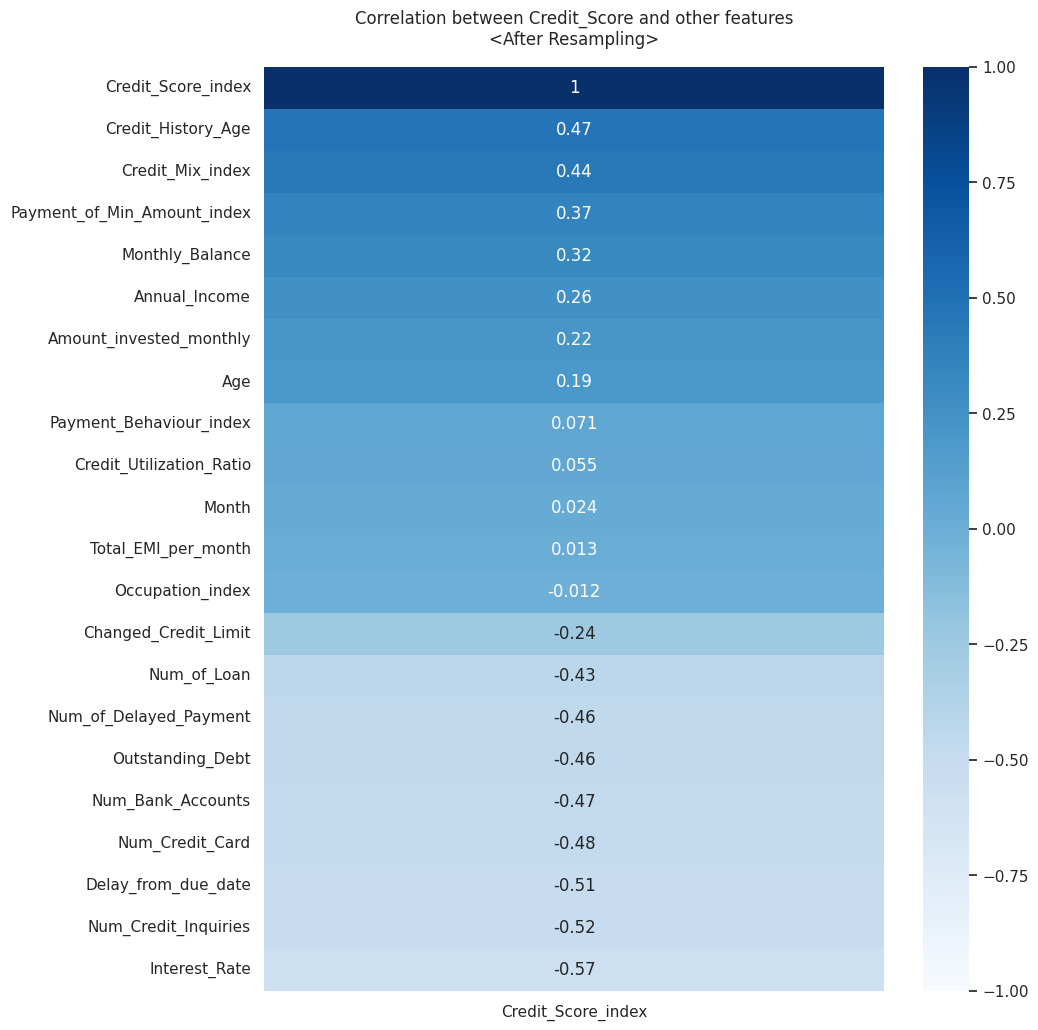

In [76]:
# Check the correlation after oversampling
df_temp = df_resampled.toPandas().drop('features', axis=1)

plt.figure(figsize=(10,12))
heatmap = sns.heatmap(df_temp.corr()[['Credit_Score_index']].sort_values(by='Credit_Score_index', ascending=False), vmin=-1, vmax=1, annot=True, cmap='Blues')
heatmap.set_title('Correlation between Credit_Score and other features\n<After Resampling>', fontdict={'fontsize':12}, pad=16)

## Split the data using Stratified Split

In [77]:
def stratified_train_test_split(df, stratify_col_name, train_fraction):
    # Separate the data into classes
    classes = df.select(stratify_col_name).distinct().collect()

    # Split each class into train and test using randomSplit
    train_data = []
    test_data = []

    for class_label in classes:
        class_df = df.filter(df[stratify_col_name] == class_label[stratify_col_name])
        splits = class_df.randomSplit([train_fraction, 1.0 - train_fraction], seed=42)

        train_data.append(splits[0])
        test_data.append(splits[1])

    # Union all the train and test sets
    train = reduce(lambda x, y: x.union(y), train_data)
    test = reduce(lambda x, y: x.union(y), test_data)

    train = train.orderBy(F.rand())
    test = test.orderBy(F.rand())

    return train, test

In [78]:
# Copy only the 'features' and 'Credit_Score_index' columns to a new DataFrame
new_df = df.select("features", "Credit_Score_index")
train, test = stratified_train_test_split(new_df, "Credit_Score_index", 0.8)

In [79]:
# Copy only the 'features' and 'Credit_Score_index' columns to a new DataFrame
new_df_resampled = df_resampled.select("features", "Credit_Score_index")
train_resampled, test_resampled = stratified_train_test_split(new_df_resampled, "Credit_Score_index", 0.8)

## Normalized the data

In [80]:
# Use standard scaler to scale the features
scaler = StandardScaler(inputCol='features', outputCol='features_scaled', withStd=True, withMean=True)

In [81]:
# Normalize the data using StandardScaler
train = scaler.fit(train).transform(train)
test = scaler.fit(test).transform(test)

In [82]:
# Normalize the data using StandardScaler
train_resampled = scaler.fit(train_resampled).transform(train_resampled)
test_resampled = scaler.fit(test_resampled).transform(test_resampled)

In [83]:
print("Before Resampling:  Train:", train.count(), ", Test:", test.count())
print("After Resampling:   Train:", train_resampled.count(), ", Test:", test_resampled.count())

Before Resampling:  Train: 80134 , Test: 19866


After Resampling:   Train: 128041 , Test: 31781


## **Diagrams after resampling**

array([[<Axes: title={'center': 'Month'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Annual_Income'}>,
        <Axes: title={'center': 'Num_Bank_Accounts'}>,
        <Axes: title={'center': 'Num_Credit_Card'}>],
       [<Axes: title={'center': 'Interest_Rate'}>,
        <Axes: title={'center': 'Num_of_Loan'}>,
        <Axes: title={'center': 'Delay_from_due_date'}>,
        <Axes: title={'center': 'Num_of_Delayed_Payment'}>,
        <Axes: title={'center': 'Num_Credit_Inquiries'}>],
       [<Axes: title={'center': 'Outstanding_Debt'}>,
        <Axes: title={'center': 'Credit_Utilization_Ratio'}>,
        <Axes: title={'center': 'Credit_History_Age'}>,
        <Axes: title={'center': 'Total_EMI_per_month'}>,
        <Axes: title={'center': 'Amount_invested_monthly'}>],
       [<Axes: title={'center': 'Monthly_Balance'}>,
        <Axes: title={'center': 'Credit_Score_index'}>,
        <Axes: title={'center': 'Credit_Mix_index'}>,
        <Axes: title={'cen

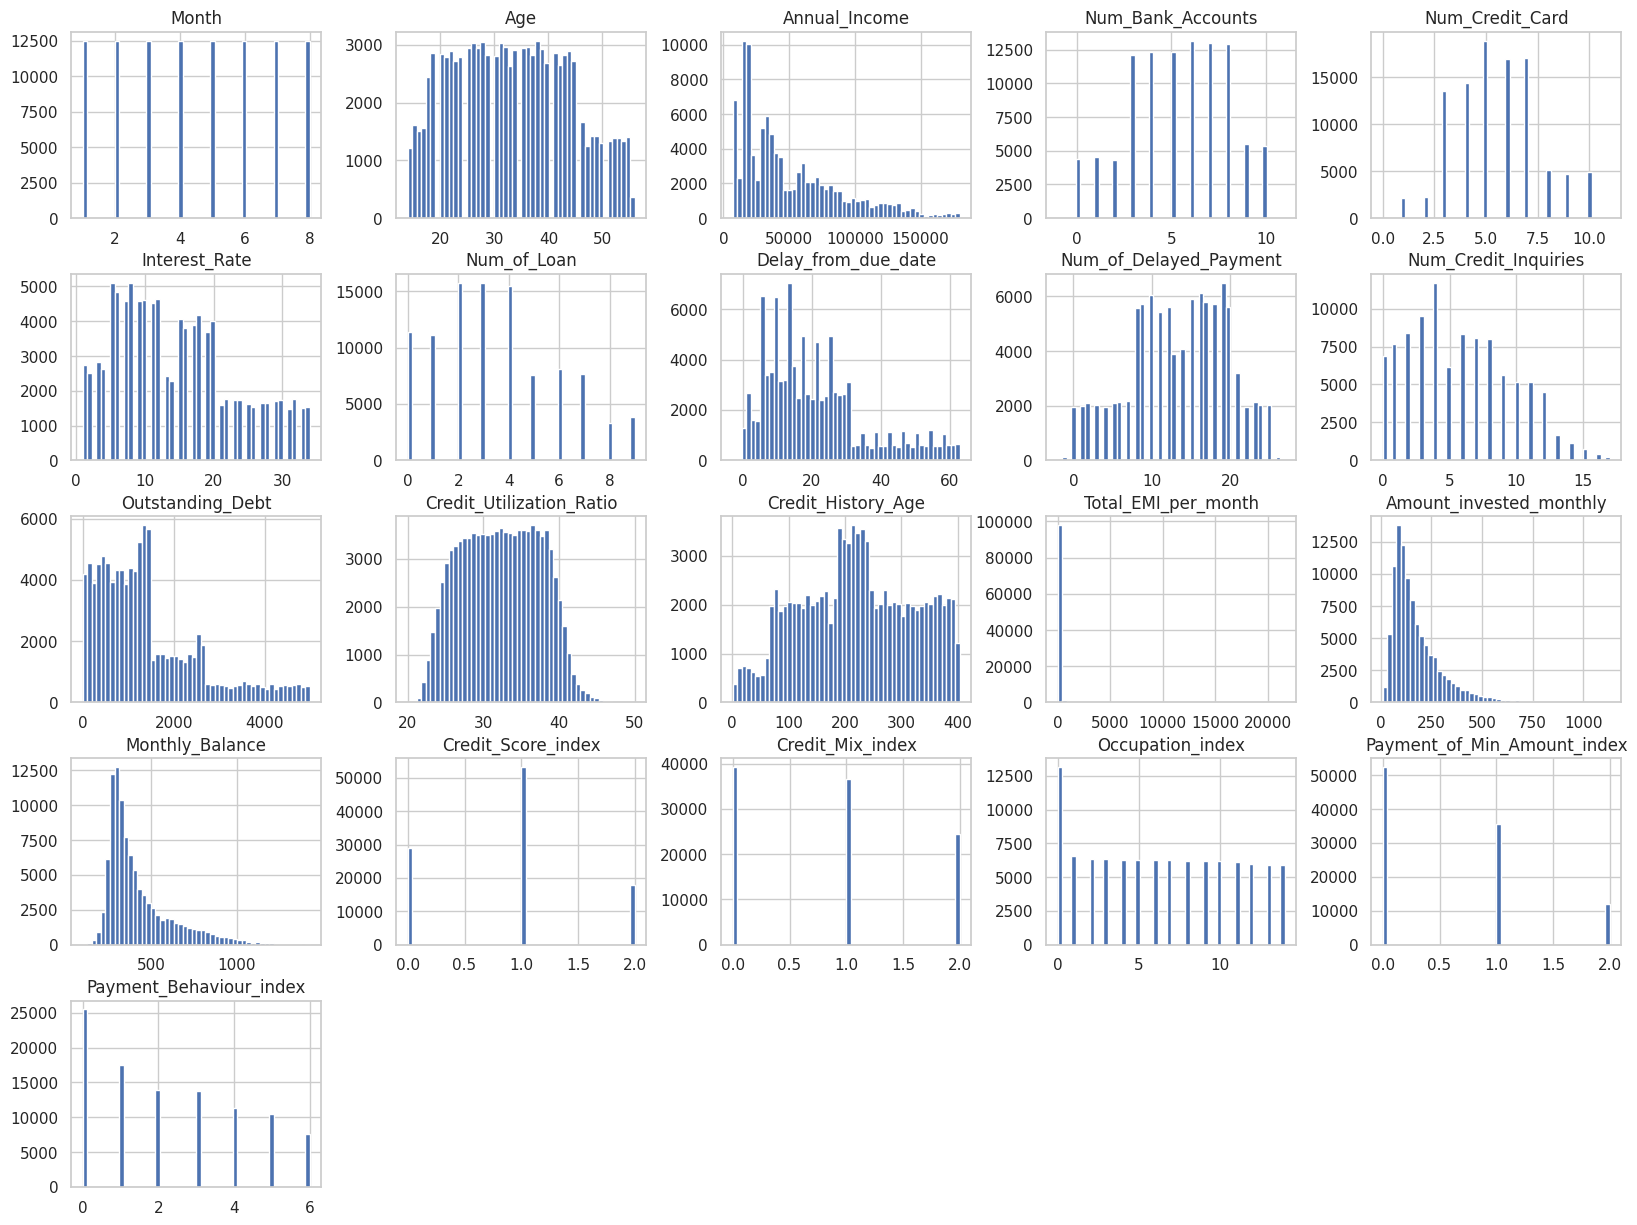

In [84]:
# Histogram before oversampling
df_toPandas = df.toPandas()
df_toPandas.hist(bins=50, figsize=(20,15))

array([[<Axes: title={'center': 'Month'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Annual_Income'}>,
        <Axes: title={'center': 'Num_Bank_Accounts'}>,
        <Axes: title={'center': 'Num_Credit_Card'}>],
       [<Axes: title={'center': 'Interest_Rate'}>,
        <Axes: title={'center': 'Num_of_Loan'}>,
        <Axes: title={'center': 'Delay_from_due_date'}>,
        <Axes: title={'center': 'Num_of_Delayed_Payment'}>,
        <Axes: title={'center': 'Num_Credit_Inquiries'}>],
       [<Axes: title={'center': 'Outstanding_Debt'}>,
        <Axes: title={'center': 'Credit_Utilization_Ratio'}>,
        <Axes: title={'center': 'Credit_History_Age'}>,
        <Axes: title={'center': 'Total_EMI_per_month'}>,
        <Axes: title={'center': 'Amount_invested_monthly'}>],
       [<Axes: title={'center': 'Monthly_Balance'}>,
        <Axes: title={'center': 'Credit_Score_index'}>,
        <Axes: title={'center': 'Credit_Mix_index'}>,
        <Axes: title={'cen

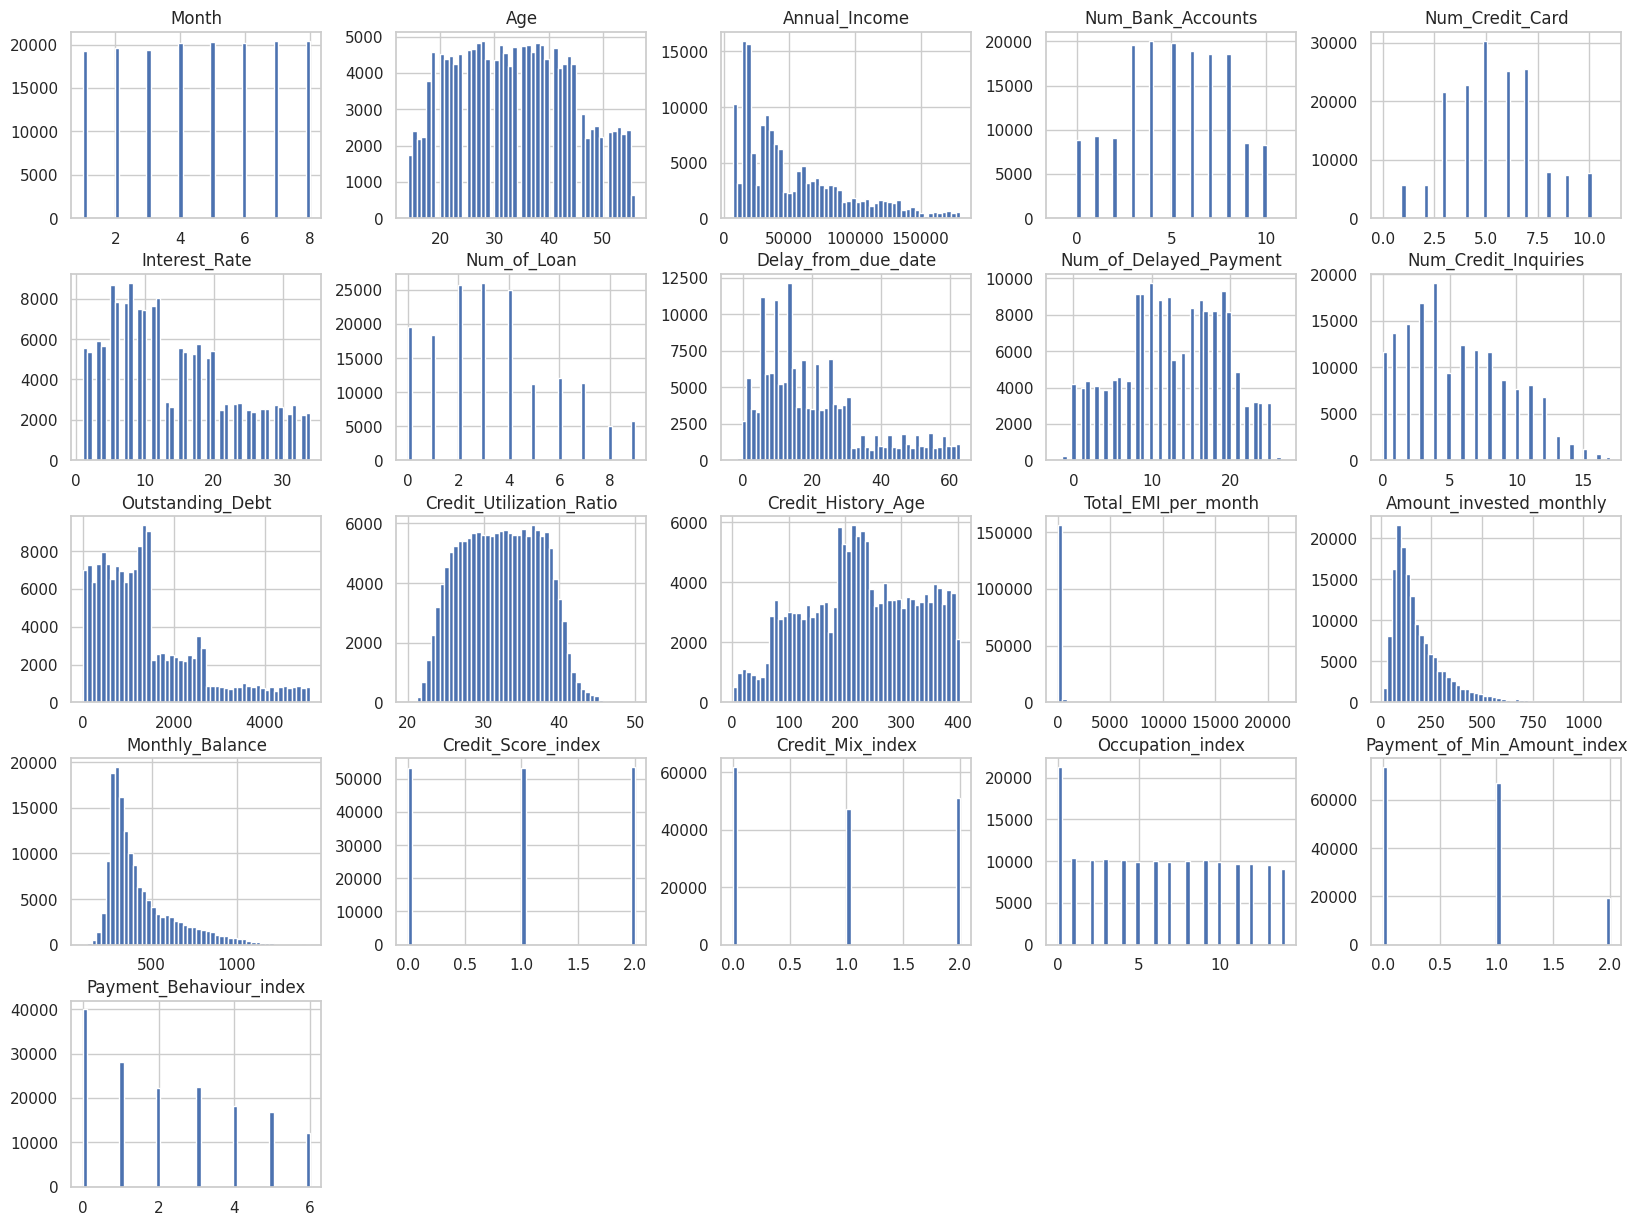

In [85]:
# Histogram after oversampling
df_toPandas_resampled = df_resampled.toPandas()
df_toPandas_resampled.hist(bins=50, figsize=(20,15))

<Axes: >

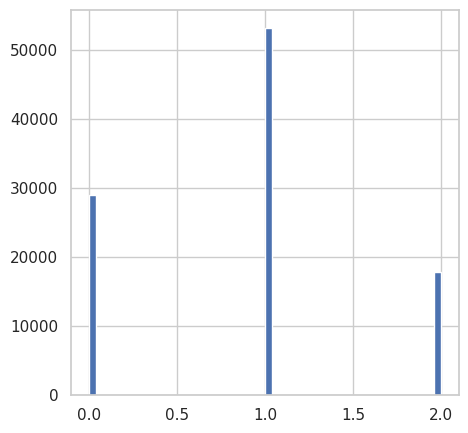

In [86]:
# Credit_Score before oversampling
df_toPandas["Credit_Score_index"].hist(bins = 50, figsize=(5,5))

<Axes: >

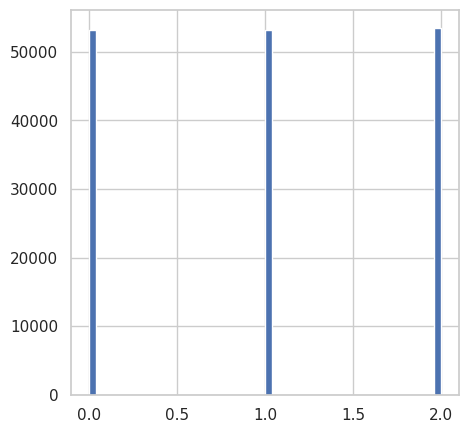

In [87]:
# Credit_Score after oversampling <training set>
df_toPandas_resampled["Credit_Score_index"].hist(bins = 50, figsize=(5,5))

# 5. Implementing the different models

## Declare the helper functions

In [88]:
# Function to print all the metrics based on each model's predictions
def model_summary(model_name, predictions):
    accuracy_eval = MulticlassClassificationEvaluator(labelCol = 'Credit_Score_index', metricName = 'accuracy')
    precision_eval = MulticlassClassificationEvaluator(labelCol = 'Credit_Score_index', metricName = 'precisionByLabel')
    recall_eval = MulticlassClassificationEvaluator(labelCol = 'Credit_Score_index', metricName = 'recallByLabel')
    f1_eval = MulticlassClassificationEvaluator(labelCol = 'Credit_Score_index', metricName = 'f1')
    evaluator = BinaryClassificationEvaluator(labelCol = 'Credit_Score_index', rawPredictionCol = 'prediction', metricName = 'areaUnderROC')

    accuracy = accuracy_eval.evaluate(predictions)
    precision = precision_eval.evaluate(predictions)
    recall = recall_eval.evaluate(predictions)
    f1 = f1_eval.evaluate(predictions)
    roc_auc = evaluator.evaluate(predictions)

    summary = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy],
        'ROC-AUC Score': [roc_auc],
        'Precision (Overall)': [precision],
        'Recall (Overall)': [recall],
        'F1-score (Overall)': [f1]
    })

    return summary

In [89]:
# Display the confusion matrix as a heatmap
def confusion_matrix_plot(model_name, confusion_matrix):
    plt.figure(figsize=(5, 3))
    sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap="Blues",\
                xticklabels=['Poor', 'Standard', 'Good'], yticklabels=['Poor', 'Standard', 'Good'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(model_name)
    plt.show()

In [90]:
# Define the Multi-class Clssification Evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="Credit_Score_index", predictionCol="prediction", metricName="accuracy")

## Logistic Regression

### Before tuning, original data

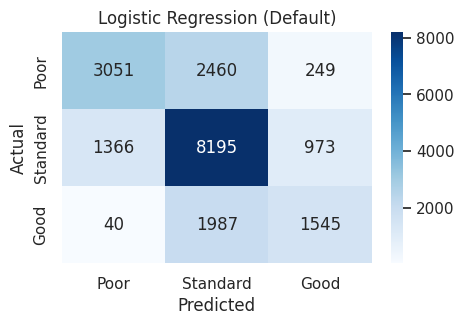

In [91]:
lr_default = LogisticRegression(featuresCol="features", labelCol="Credit_Score_index")
lr_pipeline_default = Pipeline(stages = [lr_default])
LRmodel_default = lr_pipeline_default.fit(train)

lr_result_default = LRmodel_default.transform(test)

# evaluator = MulticlassClassificationEvaluator(labelCol="Credit_Score_index", predictionCol="prediction")
lr_accuracy_default = evaluator.evaluate(lr_result_default)

# Convert DataFrame to RDD for MulticlassMetrics
lr_predictionAndLabels_default = lr_result_default.select("prediction", "Credit_Score_index").rdd

# Initialize MulticlassMetrics
lr_metrics_default = MulticlassMetrics(lr_predictionAndLabels_default)

# Create a confusion matrix
lr_confusion_matrix_default = lr_metrics_default.confusionMatrix()

# Display the confusion matrix
confusion_matrix_plot("Logistic Regression (Default)", lr_confusion_matrix_default.toArray())

In [92]:
print(f"Logistic Regression Accuracy (Before tuning, original data) : {lr_accuracy_default * 100:.5f}% ")

Logistic Regression Accuracy (Before tuning, original data) : 64.38639% 


### Before tuning, scaled data

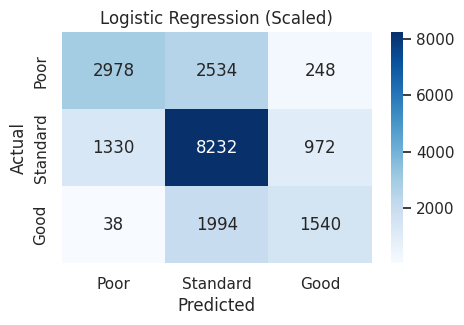

In [93]:
lr_default_scaled = LogisticRegression(featuresCol="features_scaled", labelCol="Credit_Score_index")
lr_pipeline_default_scaled = Pipeline(stages = [lr_default_scaled])
LRmodel_default_scaled = lr_pipeline_default_scaled.fit(train)

lr_result_default_scaled = LRmodel_default_scaled.transform(test)

# evaluator = MulticlassClassificationEvaluator(labelCol="Credit_Score_index", predictionCol="prediction")
lr_accuracy_scaled = evaluator.evaluate(lr_result_default_scaled)

# Convert DataFrame to RDD for MulticlassMetrics
lr_predictionAndLabels_scaled = lr_result_default_scaled.select("prediction", "Credit_Score_index").rdd

# Initialize MulticlassMetrics
lr_metrics_scaled = MulticlassMetrics(lr_predictionAndLabels_scaled)

# Create a confusion matrix
lr_confusion_matrix_scaled = lr_metrics_scaled.confusionMatrix()

# Display the confusion matrix
confusion_matrix_plot("Logistic Regression (Scaled)", lr_confusion_matrix_scaled.toArray())

In [94]:
print(f"Logistic Regression Accuracy (Before tuning, scaled data) : {lr_accuracy_scaled * 100:.5f}% ")

Logistic Regression Accuracy (Before tuning, scaled data) : 64.18001% 


### Before tuning, scaled data & oversampledData

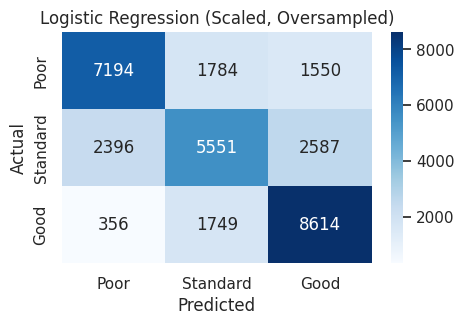

In [95]:
lr_pipeline_default_scaled_over = Pipeline(stages = [lr_default_scaled])
LRmodel_default_scaled_over = lr_pipeline_default_scaled_over.fit(train_resampled)

lr_result_default_scaled_over = LRmodel_default_scaled_over.transform(test_resampled)

# evaluator = MulticlassClassificationEvaluator(labelCol="Credit_Score_index", predictionCol="prediction")
lr_accuracy_scaled_over = evaluator.evaluate(lr_result_default_scaled_over)

# Convert DataFrame to RDD for MulticlassMetrics
lr_predictionAndLabels_default_scaled_over = lr_result_default_scaled_over.select("prediction", "Credit_Score_index").rdd

# Initialize MulticlassMetrics
lr_metrics_default_scaled_over = MulticlassMetrics(lr_predictionAndLabels_default_scaled_over)

# Create a confusion matrix
lr_confusion_matrix_default_scaled_over = lr_metrics_default_scaled_over.confusionMatrix()

# Display the confusion matrix
confusion_matrix_plot("Logistic Regression (Scaled, Oversampled)", lr_confusion_matrix_default_scaled_over.toArray())

In [96]:
print(f"Logistic Regression Accuracy (Before tuning, scaled data & oversampledData) : {lr_accuracy_scaled_over * 100:.5f}% ")

Logistic Regression Accuracy (Before tuning, scaled data & oversampledData) : 67.20682% 


### After Tuning, Original Data

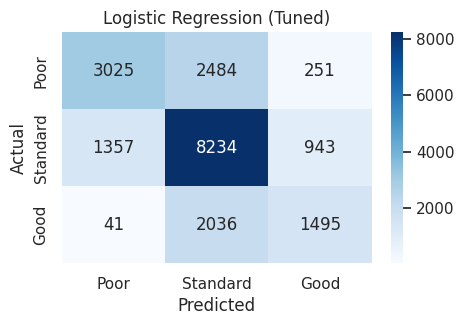

In [97]:
# Define a pipeline with Logistic Regression model
lr_pipeline = Pipeline(stages=[lr_default])

# Define grid of parameters to search
lr_paramGrid = (ParamGridBuilder()
             .addGrid(lr_default.maxIter, [50, 100, 200])  # Search for the best value of maxIter
             .addGrid(lr_default.regParam, [0.01, 0.1, 1.0])  # Search for the best value of regParam
             .build())

# Define CrossValidator with 5 folds
lr_crossval = CrossValidator(estimator=lr_pipeline,
                          estimatorParamMaps=lr_paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

# Fit CrossValidator to training data
lr_cvModel = lr_crossval.fit(train)

# Use the best model found by CrossValidator to make predictions on the test data
lr_result_tuned = lr_cvModel.transform(test)

# Convert DataFrame to RDD for MulticlassMetrics
lr_predictionAndLabels_cv = lr_result_tuned.select("prediction", "Credit_Score_index").rdd

# Initialize MulticlassMetrics
lr_metrics_cv = MulticlassMetrics(lr_predictionAndLabels_cv)

# Create a confusion matrix
lr_confusion_matrix_cv = lr_metrics_cv.confusionMatrix()

# Display the confusion matrix
confusion_matrix_plot("Logistic Regression (Tuned)", lr_confusion_matrix_cv.toArray())

In [98]:
# Evaluate the performance of the best model
lr_accuracy_tuned = evaluator.evaluate(lr_result_tuned)

print(f"Logistic Regression Accuracy (After tuning, original data) : {lr_accuracy_tuned * 100:.5f}% ")

Logistic Regression Accuracy (After tuning, original data) : 64.20014% 


### After Tuning, scaled Data

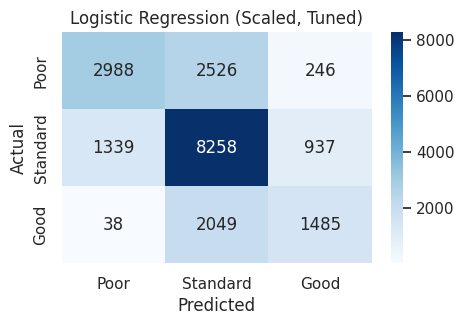

In [99]:
# Define a pipeline with Logistic Regression model
lr_pipeline_scaled = Pipeline(stages=[lr_default_scaled])

# Define grid of parameters to search
lr_paramGrid = (ParamGridBuilder()
             .addGrid(lr_default_scaled.maxIter, [50, 100, 200])  # Search for the best value of maxIter
             .addGrid(lr_default_scaled.regParam, [0.01, 0.1, 1.0])  # Search for the best value of regParam
             .build())

# Define CrossValidator with 5 folds
lr_crossval_scaled = CrossValidator(estimator=lr_pipeline_scaled,
                          estimatorParamMaps=lr_paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

# Fit CrossValidator to training data
lr_cvModel_scaled = lr_crossval_scaled.fit(train)

# Use the best model found by CrossValidator to make predictions on the test data
lr_result_tuned_scaled = lr_cvModel_scaled.transform(test)

# Convert DataFrame to RDD for MulticlassMetrics
lr_predictionAndLabels_cv_scaled = lr_result_tuned_scaled.select("prediction", "Credit_Score_index").rdd

# Initialize MulticlassMetrics
lr_metrics_cv_scaled = MulticlassMetrics(lr_predictionAndLabels_cv_scaled)

# Create a confusion matrix
lr_confusion_matrix_cv_scaled = lr_metrics_cv_scaled.confusionMatrix()

# Display the confusion matrix
confusion_matrix_plot("Logistic Regression (Scaled, Tuned)", lr_confusion_matrix_cv_scaled.toArray())

In [100]:
# Evaluate the performance of the best model
lr_accuracy_tuned_scaled = evaluator.evaluate(lr_result_tuned_scaled)

print(f"Logistic Regression Accuracy (After tuning, scaled data) : {lr_accuracy_tuned_scaled * 100:.5f}% ")

Logistic Regression Accuracy (After tuning, scaled data) : 64.08437% 


### After Tuning, scaled & oversampled Data

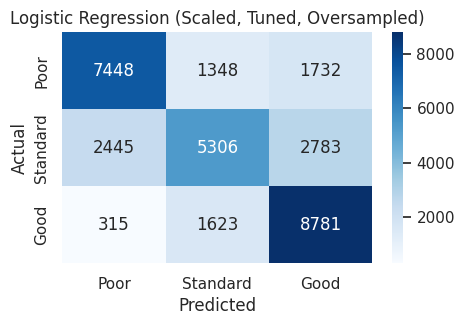

In [101]:
# Define a pipeline with Logistic Regression model
lr_pipeline_scaled = Pipeline(stages=[lr_default_scaled])

# Define grid of parameters to search
lr_paramGrid = (ParamGridBuilder()
             .addGrid(lr_default_scaled.maxIter, [50, 100, 200])  # Search for the best value of maxIter
             .addGrid(lr_default_scaled.regParam, [0.01, 0.1, 1.0])  # Search for the best value of regParam
             .build())

# Define CrossValidator with 5 folds
lr_crossval = CrossValidator(estimator=lr_pipeline_scaled,
                          estimatorParamMaps=lr_paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

# Fit CrossValidator to training data
lr_cvModel_scaled_over = lr_crossval.fit(train_resampled)

# Use the best model found by CrossValidator to make predictions on the test data
lr_result_tuned_scaled_over = lr_cvModel_scaled_over.transform(test_resampled)

# Convert DataFrame to RDD for MulticlassMetrics
lr_predictionAndLabels_cv_scaled_over = lr_result_tuned_scaled_over.select("prediction", "Credit_Score_index").rdd

# Initialize MulticlassMetrics
lr_metrics_cv_scaled_over = MulticlassMetrics(lr_predictionAndLabels_cv_scaled_over)

# Create a confusion matrix
lr_confusion_matrix_cv_scaled_over = lr_metrics_cv_scaled_over.confusionMatrix()

# Display the confusion matrix
confusion_matrix_plot("Logistic Regression (Scaled, Tuned, Oversampled)", lr_confusion_matrix_cv_scaled_over.toArray())

In [102]:
# Evaluate the performance of the best model
lr_accuracy_tuned_scaled_over = evaluator.evaluate(lr_result_tuned_scaled_over)

print(f"Logistic Regression Accuracy (After tuning, scaled & oversampled data) : {lr_accuracy_tuned_scaled_over * 100:.5f}% ")

Logistic Regression Accuracy (After tuning, scaled & oversampled data) : 67.76061% 


### Comparison of the results

In [103]:
lr_basic_summary = model_summary('Logistic Regression (Basic)', lr_result_default)
lr_scaled_summary = model_summary('Logistic Regression (Normalized)', lr_result_default_scaled)
lr_resampled_summary = model_summary('Logistic Regression (Resampled)', lr_result_default_scaled_over)
lr_tuned_summary = model_summary('Logistic Regression (Tuned)', lr_result_tuned)
lr_tuned_scaled_summary = model_summary('Logistic Regression (Tuned + Normalized)', lr_result_tuned_scaled)
lr_tuned_scaled_over_summary = model_summary('Logistic Regression (Tuned + Normalized + Resampled)', lr_result_tuned_scaled_over)

lr_summary = pd.concat([lr_basic_summary, lr_scaled_summary, lr_resampled_summary, lr_tuned_summary, lr_tuned_scaled_summary, lr_tuned_scaled_over_summary])
lr_summary

,Model,Accuracy,ROC-AUC Score,Precision (Overall),Recall (Overall),F1-score (Overall)
0,Logistic Regression (Basic),0.643864,0.737523,0.684541,0.529687,0.635806
0,Logistic Regression (Normalized),0.641800,0.733582,0.685228,0.517014,0.633117
0,Logistic Regression (Resampled),0.672068,0.796285,0.723306,0.683321,0.667946
0,Logistic Regression (Tuned),0.642001,0.734438,0.683925,0.525174,0.633096
0,Logistic Regression (Tuned + Normalized),0.640844,0.732612,0.684536,0.518750,0.631498
0,Logistic Regression (Tuned + Normalized + Resa...,0.677606,0.796808,0.729624,0.707447,0.671606


## Artificial Neural Networks (ANN)

In [104]:
inputLength = len(assembler.getInputCols())
print(inputLength)

21


In [105]:
# Defining the layers for the neural network
mlp_default = MultilayerPerceptronClassifier(featuresCol="features",
                                             labelCol="Credit_Score_index",
                                             maxIter=100,
                                             layers=[inputLength, 64, 32, 3],
                                             blockSize=128, seed=42)

mlp_scaled = MultilayerPerceptronClassifier(featuresCol="features_scaled",
                                            labelCol="Credit_Score_index",
                                            maxIter=100,
                                            layers=[inputLength, 64, 32, 3],
                                            blockSize=128, seed=42)

### Before tuning, original data

Accuracy : 0.566973886328725


                             Model  Accuracy  ROC-AUC Score  \
0  Multilayer Perceptron (Default)  0.566974       0.652626   

   Precision (Overall)  Recall (Overall)  F1-score (Overall)  
0             0.557625          0.450682            0.502944  


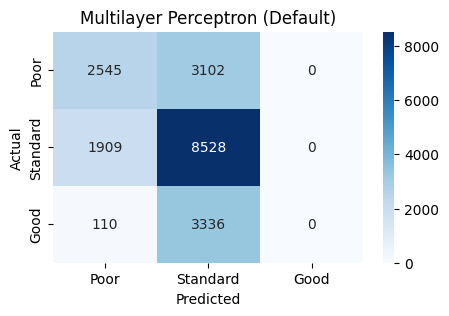

In [106]:
# Fit the pipeline with the updated train DataFrame
mlp_pipeline_default = Pipeline(stages=[mlp_default])
mlp_model_default = mlp_pipeline_default.fit(train)

# Transform the test DataFrame using the fitted pipeline
mlp_results_default = mlp_model_default.transform(test)

mlp_accuracy_default = evaluator.evaluate(mlp_results_default)

mlp_predictionAndLabels_default = mlp_results_default.select("prediction", "Credit_Score_index").rdd
mlp_metrics_default = MulticlassMetrics(mlp_predictionAndLabels_default)
mlp_confusion_matrix_default = mlp_metrics_default.confusionMatrix()

print("Accuracy :", mlp_accuracy_default)
print(model_summary('Multilayer Perceptron (Default)', mlp_results_default))
confusion_matrix_plot('Multilayer Perceptron (Default)', mlp_confusion_matrix_default.toArray())

### Before tuning, scaled data

Accuracy (Scaled) : 0.6930875576036867


                            Model  Accuracy  ROC-AUC Score  \
0  Multilayer Perceptron (Scaled)  0.693088       0.785059   

   Precision (Overall)  Recall (Overall)  F1-score (Overall)  
0             0.709998          0.645121            0.692092  


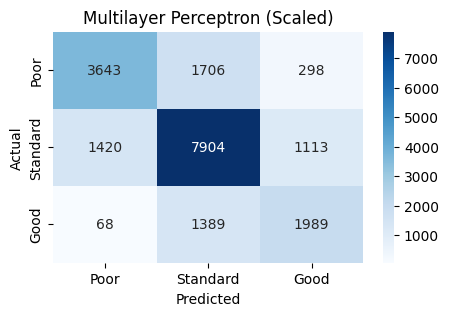

In [107]:
# Fit the pipeline with the updated train DataFrame
mlp_pipeline_scaled = Pipeline(stages=[mlp_scaled])
mlp_model_scaled = mlp_pipeline_scaled.fit(train)

# Transform the test DataFrame using the fitted pipeline
mlp_results_scaled = mlp_model_scaled.transform(test)

mlp_accuracy_scaled = evaluator.evaluate(mlp_results_scaled)

mlp_predictionAndLabels_scaled = mlp_results_scaled.select("prediction", "Credit_Score_index").rdd
mlp_metrics_scaled = MulticlassMetrics(mlp_predictionAndLabels_scaled)
mlp_confusion_matrix_scaled = mlp_metrics_scaled.confusionMatrix()

print("Accuracy (Scaled) :", mlp_accuracy_scaled)
print(model_summary('Multilayer Perceptron (Scaled)', mlp_results_scaled))
confusion_matrix_plot('Multilayer Perceptron (Scaled)', mlp_confusion_matrix_scaled.toArray())

### Before tuning, over-sampled data

Accuracy (Oversampling) : 0.52608033504664


                                  Model  Accuracy  ROC-AUC Score  \
0  Multilayer Perceptron (Oversampling)   0.52608       0.734301   

   Precision (Overall)  Recall (Overall)  F1-score (Overall)  
0             0.632194          0.657819             0.42316  


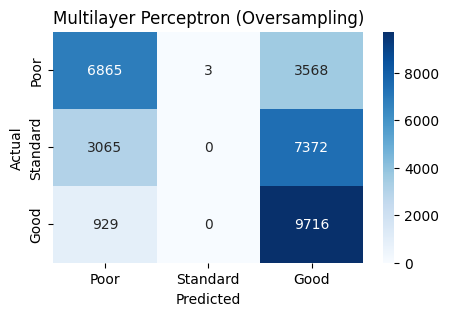

In [108]:
# Fit the pipeline with the updated train DataFrame
mlp_pipeline_oversample = Pipeline(stages=[mlp_default])
mlp_model_oversample = mlp_pipeline_oversample.fit(train_resampled)

# Transform the test DataFrame using the fitted pipeline
mlp_results_oversample = mlp_model_oversample.transform(test_resampled)

mlp_accuracy_oversample = evaluator.evaluate(mlp_results_oversample)

mlp_predictionAndLabels_oversample = mlp_results_oversample.select("prediction", "Credit_Score_index").rdd
mlp_metrics_oversample = MulticlassMetrics(mlp_predictionAndLabels_oversample)
mlp_confusion_matrix_oversample = mlp_metrics_oversample.confusionMatrix()

print("Accuracy (Oversampling) :", mlp_accuracy_oversample)
print(model_summary('Multilayer Perceptron (Oversampling)', mlp_results_oversample))
confusion_matrix_plot('Multilayer Perceptron (Oversampling)', mlp_confusion_matrix_oversample.toArray())

> Faces **Exploding gradient problem**.
>
>This can happen when the data is not in the same range. When some of the data has extrimely higher values then the others, the loss function may did not work properly.
>To solve this, we need to normalize the data.

### Before tuning, scaled & over-sampled data

Accuracy (After scaling + Oversampling) : 0.7088965035852529


                                               Model  Accuracy  ROC-AUC Score  \
0  Multilayer Perceptron (Oversampling + Normaliz...  0.708897       0.826288   

   Precision (Overall)  Recall (Overall)  F1-score (Overall)  
0             0.748706          0.762553            0.704427  


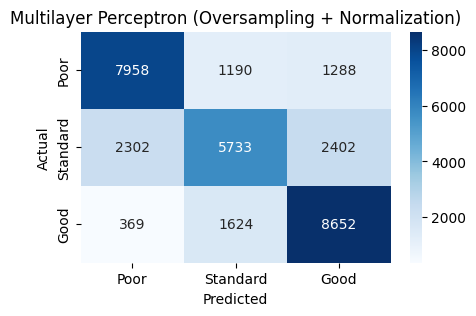

In [109]:
# Fit the pipeline with the updated train DataFrame
mlp_pipeline_normalized = Pipeline(stages=[mlp_scaled])
mlp_model_normalized = mlp_pipeline_normalized.fit(train_resampled)

# Transform the test DataFrame using the fitted pipeline
mlp_results_normalized = mlp_model_normalized.transform(test_resampled)

mlp_accuracy_normalized = evaluator.evaluate(mlp_results_normalized)

mlp_predictionAndLabels_normalized = mlp_results_normalized.select("prediction", "Credit_Score_index").rdd
mlp_metrics_normalized = MulticlassMetrics(mlp_predictionAndLabels_normalized)
mlp_confusion_matrix_normalized = mlp_metrics_normalized.confusionMatrix()

print("Accuracy (After scaling + Oversampling) :", mlp_accuracy_normalized)
print(model_summary('Multilayer Perceptron (Oversampling + Normalization)', mlp_results_normalized))
confusion_matrix_plot('Multilayer Perceptron (Oversampling + Normalization)', mlp_confusion_matrix_normalized.toArray())

### Hyper-parameter tuning the ANN with scaled & over-sampled data

In [110]:
# Check the current parameters
mlp_model_oversample.stages[0].extractParamMap()

{Param(parent='MultilayerPerceptronClassifier_e53b4d0a25c7', name='blockSize', doc='block size for stacking input data in matrices. Data is stacked within partitions. If block size is more than remaining data in a partition then it is adjusted to the size of this data.'): 128,
 Param(parent='MultilayerPerceptronClassifier_e53b4d0a25c7', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='MultilayerPerceptronClassifier_e53b4d0a25c7', name='labelCol', doc='label column name.'): 'Credit_Score_index',
 Param(parent='MultilayerPerceptronClassifier_e53b4d0a25c7', name='maxIter', doc='max number of iterations (>= 0).'): 100,
 Param(parent='MultilayerPerceptronClassifier_e53b4d0a25c7', name='predictionCol', doc='prediction column name.'): 'prediction',
 Param(parent='MultilayerPerceptronClassifier_e53b4d0a25c7', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These

Accuracy (After Hyperparameter Tuning) : 0.712217991881942


                                      Model  Accuracy  ROC-AUC Score  \
0  Multilayer Perceptron (Cross-Validation)  0.712218       0.825597   

   Precision (Overall)  Recall (Overall)  F1-score (Overall)  
0             0.733138           0.78258            0.706118  


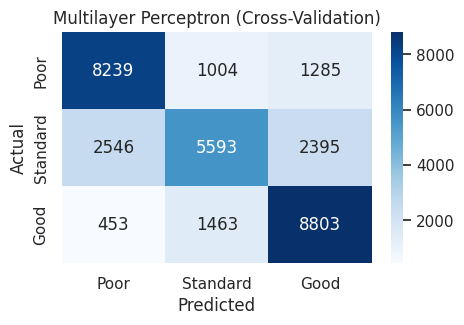

In [111]:
mlp_paramGrid = ParamGridBuilder() \
    .addGrid(mlp_scaled.layers, [(inputLength, 64, 32, 3),
                                 (inputLength, 128, 64, 32, 3),
                                 (inputLength, 256, 128, 128, 64, 3)])\
    .addGrid(mlp_scaled.solver, ['l-bfgs', 'gd'])\
    .addGrid(mlp_scaled.blockSize, [64, 128])\
    .addGrid(mlp_scaled.stepSize, [0.03, 0.1, 0.3])\
    .build()

mlp_crossVal = CrossValidator(estimator=mlp_pipeline_normalized,
                          estimatorParamMaps=mlp_paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol='Credit_Score_index'),
                          numFolds=2)

mlp_cvModel = mlp_crossVal.fit(train_resampled)

mlp_result_cv = mlp_cvModel.transform(test_resampled)
mlp_bestModel = mlp_cvModel.bestModel
# Show the best model
mlp_bestModel.stages[0].extractParamMap()
mlp_accuracy_cv = evaluator.evaluate(mlp_result_cv)

mlp_predictionAndLabels_cv = mlp_result_cv.select("prediction", "Credit_Score_index").rdd
mlp_metrics_cv = MulticlassMetrics(mlp_predictionAndLabels_cv)
mlp_confusion_matrix_cv = mlp_metrics_cv.confusionMatrix()

print("Accuracy (After Hyperparameter Tuning) :", mlp_accuracy_cv)
print(model_summary('Multilayer Perceptron (Cross-Validation)', mlp_result_cv))
confusion_matrix_plot('Multilayer Perceptron (Cross-Validation)', mlp_confusion_matrix_cv.toArray())

In [112]:
# Show the best model
mlp_bestModel.stages[0].extractParamMap()

{Param(parent='MultilayerPerceptronClassifier_e9878a37f6d3', name='blockSize', doc='block size for stacking input data in matrices. Data is stacked within partitions. If block size is more than remaining data in a partition then it is adjusted to the size of this data.'): 64,
 Param(parent='MultilayerPerceptronClassifier_e9878a37f6d3', name='featuresCol', doc='features column name.'): 'features_scaled',
 Param(parent='MultilayerPerceptronClassifier_e9878a37f6d3', name='labelCol', doc='label column name.'): 'Credit_Score_index',
 Param(parent='MultilayerPerceptronClassifier_e9878a37f6d3', name='maxIter', doc='max number of iterations (>= 0).'): 100,
 Param(parent='MultilayerPerceptronClassifier_e9878a37f6d3', name='predictionCol', doc='prediction column name.'): 'prediction',
 Param(parent='MultilayerPerceptronClassifier_e9878a37f6d3', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates!

### Comparison of the results

In [113]:
ann_basic_summary = model_summary('ANN (Basic)', mlp_results_default)
ann_scaled_summary = model_summary('ANN (Normalized)', mlp_results_scaled)
ann_resampled_summary = model_summary('ANN (Resampled)', mlp_results_oversample)
ann_normalized_summary = model_summary('ANN (Normalized + Resampled)', mlp_results_normalized)
ann_tuned_summary = model_summary('ANN (Tuned + Normalized + Resampled)', mlp_result_cv)

ann_summary = pd.concat([ann_basic_summary, ann_scaled_summary, ann_resampled_summary, ann_normalized_summary, ann_tuned_summary])
ann_summary

,Model,Accuracy,ROC-AUC Score,Precision (Overall),Recall (Overall),F1-score (Overall)
0,ANN (Basic),0.566974,0.652626,0.557625,0.450682,0.502944
0,ANN (Normalized),0.693088,0.785059,0.709998,0.645121,0.692092
0,ANN (Resampled),0.526080,0.734301,0.632194,0.657819,0.423160
0,ANN (Normalized + Resampled),0.708897,0.826288,0.748706,0.762553,0.704427
0,ANN (Tuned + Normalized + Resampled),0.712218,0.825597,0.733138,0.782580,0.706118


>Normalization is a significant factor in ANN. It can improve the accuracy of the model.
>
>The ROC-AUC score of the model with normalizad data is above 0.82, which is higher than the model without normalization.
>This means that the model with normalized data is more accurate(less random) than the model without normalization.
>
>From the findings from **Assignment 1**, the best activation function was ***'relu'*** and ***'tanh'***, and the best solver was ***'adam'***. But the Spark MLlib support only ***'sigmoid'*** for activation function, ***'l-bfgs'*** and ***'sgd'*** as solver, which showed poor performance in scikit-learn. This can be considered as a reason why the model accuracy is not as high as the model in Assignment 1.

## Decision Tree

### Default Decision Tree Model

+--------------------+------------------+--------------------+--------------------+--------------------+----------+
|            features|Credit_Score_index|     features_scaled|       rawPrediction|         probability|prediction|
+--------------------+------------------+--------------------+--------------------+--------------------+----------+
|[1.0,32.0,28806.0...|               1.0|[-1.5186985063700...|[3243.0,25786.0,4...|[0.09715689505377...|       1.0|
|[8.0,44.0,37464.0...|               1.0|[1.53591975094968...|[9280.0,2909.0,37.0]|[0.75903811549157...|       0.0|
|[5.0,29.0,20790.0...|               0.0|[0.22679764066981...|[3243.0,25786.0,4...|[0.09715689505377...|       1.0|
|[1.0,55.0,176015....|               1.0|[-1.5186985063700...|[702.0,1949.0,144...|[0.17155425219941...|       1.0|
|[5.0,40.0,31357.0...|               1.0|[0.22679764066981...|[1005.0,3644.0,50...|[0.10364030112405...|       2.0|
+--------------------+------------------+--------------------+----------

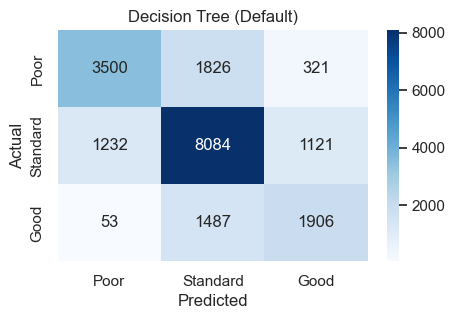

In [114]:
# Default DT Model
dt_default = DecisionTreeClassifier(labelCol = 'Credit_Score_index', featuresCol = 'features')
dt_pipeline_default = Pipeline(stages=[dt_default])
dt_model_default = dt_pipeline_default.fit(train)

# select example rows to display.
dt_results_default = dt_model_default.transform(test)
dt_results_default.show(5)

dt_predictionAndLabels_default = dt_results_default.select("prediction", "Credit_Score_index").rdd
dt_metrics_default = MulticlassMetrics(dt_predictionAndLabels_default)
dt_confusion_matrix_default = dt_metrics_default.confusionMatrix()

print(model_summary('Decision Tree (Default)', dt_results_default))
confusion_matrix_plot('Decision Tree (Default)', dt_confusion_matrix_default.toArray())

Tuned predictions for DecisionTreeClassificationModel: uid=DecisionTreeClassifier_399883cff332, depth=15, numNodes=9857, numClasses=3, numFeatures=21:
Best DT Impurity: gini
Best DT Min Instances Per Node: 1
Best DT Max Bins: 4

                           Model  Accuracy  ROC-AUC Score  \
0  Decision Tree (Default Tuned)   0.71362        0.80738   

   Precision (Overall)  Recall (Overall)  F1-score (Overall)  
0             0.708738           0.69807             0.71383  


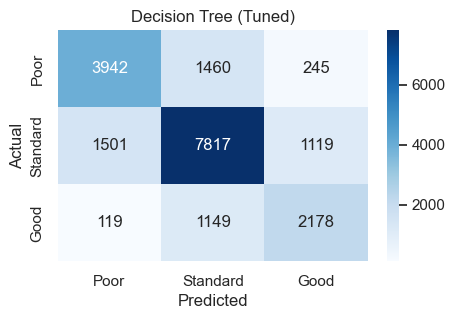

In [115]:
# Parameter grids
dt_paramGrid = (ParamGridBuilder()
            .addGrid(dt_default.impurity, ['gini', 'entropy'])
            .addGrid(dt_default.maxDepth, [5, 10, 15])
            .addGrid(dt_default.maxBins, [2,4]) # Going over "4" bins will slightly increase the accuracy but it is not worth the computational power
            .build())

dt_crossval = CrossValidator(estimator=dt_pipeline_default,
                          estimatorParamMaps=dt_paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

# Train the model using the training set find the best parameters for the model from the parameter grid
tunedDTModel = dt_crossval.fit(train)
dt_best_model = tunedDTModel.bestModel

# Extract the Decision Tree classifier from the pipeline
best_dt_model = dt_best_model.stages[-1]

# Display tuned model's performance
dt_tuned_predictions = dt_best_model.transform(test)

dt_predictionAndLabels_default_tuned = dt_tuned_predictions.select("prediction", "Credit_Score_index").rdd
dt_metrics_default_tuned = MulticlassMetrics(dt_predictionAndLabels_default_tuned)
dt_confusion_matrix_default_tuned = dt_metrics_default_tuned.confusionMatrix()

print(f"Tuned predictions for {best_dt_model}:")
print(f"Best DT Impurity: {best_dt_model.getImpurity()}")
print(f"Best DT Min Instances Per Node: {best_dt_model.getMinInstancesPerNode()}")
print(f"Best DT Max Bins: {best_dt_model.getMaxBins()}")


print()
print(model_summary('Decision Tree (Default Tuned)', dt_tuned_predictions))
confusion_matrix_plot('Decision Tree (Tuned)', dt_confusion_matrix_default_tuned.toArray())

### Normalized Decision Tree Model

+--------------------+------------------+--------------------+--------------------+--------------------+----------+
|            features|Credit_Score_index|     features_scaled|       rawPrediction|         probability|prediction|
+--------------------+------------------+--------------------+--------------------+--------------------+----------+
|[1.0,32.0,28806.0...|               1.0|[-1.5186985063700...|[3303.0,25870.0,4...|[0.09847942754919...|       1.0|
|[8.0,44.0,37464.0...|               1.0|[1.53591975094968...|[9118.0,2809.0,32.0]|[0.76243833096412...|       0.0|
|[5.0,29.0,20790.0...|               0.0|[0.22679764066981...|[3303.0,25870.0,4...|[0.09847942754919...|       1.0|
|[1.0,55.0,176015....|               1.0|[-1.5186985063700...|[702.0,1954.0,144...|[0.17126128323981...|       1.0|
|[5.0,40.0,31357.0...|               1.0|[0.22679764066981...|[1008.0,3645.0,50...|[0.10390681373054...|       2.0|
+--------------------+------------------+--------------------+----------

                        Model  Accuracy  ROC-AUC Score  Precision (Overall)  \
0  Decision Tree (Normalized)  0.691347       0.778566             0.739093   

   Recall (Overall)  F1-score (Overall)  
0          0.612006             0.68929  


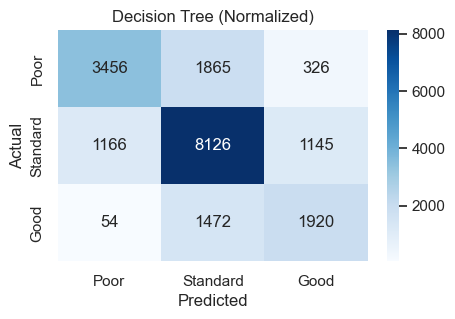

In [116]:
# Normalize DT Model
dt_normalize = DecisionTreeClassifier(labelCol = 'Credit_Score_index', featuresCol = 'features_scaled')
dt_pipeline_normalize = Pipeline(stages=[dt_normalize])
dt_model_normalize = dt_pipeline_normalize.fit(train)


# select example rows to display.
dt_results_normalize = dt_model_normalize.transform(test)
dt_results_normalize.show(5)

dt_predictionAndLabels_normalize = dt_results_normalize.select("prediction", "Credit_Score_index").rdd
dt_metrics_normalize = MulticlassMetrics(dt_predictionAndLabels_normalize)
dt_confusion_matrix_normalize = dt_metrics_normalize.confusionMatrix()

print(model_summary('Decision Tree (Normalized)', dt_results_normalize))
confusion_matrix_plot('Decision Tree (Normalized)', dt_confusion_matrix_normalize.toArray())

Tuned predictions for DecisionTreeClassificationModel: uid=DecisionTreeClassifier_3ebfbb25f160, depth=15, numNodes=11483, numClasses=3, numFeatures=21:
Best DT Impurity: gini
Best DT Min Instances Per Node: 1
Best DT Max Bins: 4



                                Model  Accuracy  ROC-AUC Score  \
0  Decision Tree (Normalized + Tuned)   0.70297        0.79568   

   Precision (Overall)  Recall (Overall)  F1-score (Overall)  
0             0.697517          0.676642            0.703333  


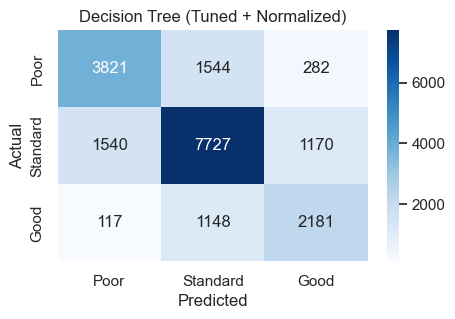

In [117]:
# Parameter grids
dt_paramGrid = (ParamGridBuilder()
            .addGrid(dt_normalize.impurity, ['gini', 'entropy'])
            .addGrid(dt_normalize.maxDepth, [5, 10, 15])
            .addGrid(dt_normalize.maxBins, [2,4])
            .build())

crossval = CrossValidator(estimator=dt_pipeline_normalize,
                          estimatorParamMaps=dt_paramGrid,
                          evaluator=evaluator,
                          numFolds=5)


# Train the model using the training set find the best parameters for the model from the parameter grid
tunedDTModel_normalize = crossval.fit(train)
dt_best_model_norm = tunedDTModel_normalize.bestModel

# Extract the Decision Tree classifier from the pipeline
best_dt_model_norm = dt_best_model_norm.stages[-1]

# Display tuned model's performance
dt_tuned_normalized_predictions = dt_best_model_norm.transform(test)

dt_predictionAndLabels_normalize_tuned = dt_tuned_normalized_predictions.select("prediction", "Credit_Score_index").rdd
dt_metrics_normalize_tuned = MulticlassMetrics(dt_predictionAndLabels_normalize_tuned)
dt_confusion_matrix_normalize_tuned = dt_metrics_normalize_tuned.confusionMatrix()

print(f"Tuned predictions for {best_dt_model_norm}:")
print(f"Best DT Impurity: {best_dt_model_norm.getImpurity()}")
print(f"Best DT Min Instances Per Node: {best_dt_model_norm.getMinInstancesPerNode()}")
print(f"Best DT Max Bins: {best_dt_model_norm.getMaxBins()}")
print()
print(model_summary('Decision Tree (Normalized + Tuned)', dt_tuned_normalized_predictions))
confusion_matrix_plot('Decision Tree (Tuned + Normalized)', dt_confusion_matrix_normalize_tuned.toArray())

### Oversampled Decision Tree Model

+--------------------+------------------+--------------------+--------------------+--------------------+----------+
|            features|Credit_Score_index|     features_scaled|       rawPrediction|         probability|prediction|
+--------------------+------------------+--------------------+--------------------+--------------------+----------+
|[4.0,49.0,37188.0...|               2.0|[-0.2266189181776...|[3084.0,6131.0,25...|[0.08850370200309...|       2.0|
|[4.0,34.0,26150.0...|               1.0|[-0.2266189181776...|[3084.0,6131.0,25...|[0.08850370200309...|       2.0|
|[1.0,47.0,22323.0...|               2.0|[-1.5380129164670...|[3084.0,6131.0,25...|[0.08850370200309...|       2.0|
|[5.0,36.0,49216.0...|               1.0|[0.21051241458542...|[6420.0,4905.0,85...|[0.52718016094596...|       0.0|
|[8.0,35.0,72331.0...|               2.0|[1.52190641287477...|[3084.0,6131.0,25...|[0.08850370200309...|       2.0|
+--------------------+------------------+--------------------+----------

                                    Model  Accuracy  ROC-AUC Score  \
0  Decision Tree (Normalized + Resampled)  0.714957       0.831554   

   Precision (Overall)  Recall (Overall)  F1-score (Overall)  
0             0.735768          0.783921            0.710115  


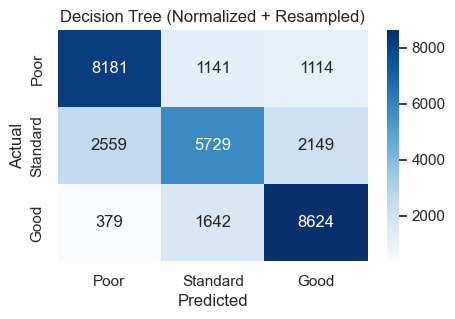

In [118]:
# Oversample DT Model
dt_oversample = DecisionTreeClassifier(labelCol = 'Credit_Score_index', featuresCol = 'features_scaled')
dt_pipeline_oversample = Pipeline(stages=[dt_oversample])
dt_model_oversample = dt_pipeline_oversample.fit(train_resampled)


# select example rows to display.
dt_results_oversample = dt_model_oversample.transform(test_resampled)
dt_results_oversample.show(5)

dt_predictionAndLabels_oversample = dt_results_oversample.select("prediction", "Credit_Score_index").rdd
dt_metrics_oversample = MulticlassMetrics(dt_predictionAndLabels_oversample)
dt_confusion_matrix_oversample = dt_metrics_oversample.confusionMatrix()

print(model_summary('Decision Tree (Normalized + Resampled)', dt_results_oversample))
confusion_matrix_plot('Decision Tree (Normalized + Resampled)', dt_confusion_matrix_oversample.toArray())

Tuned predictions for DecisionTreeClassificationModel: uid=DecisionTreeClassifier_399883cff332, depth=15, numNodes=9857, numClasses=3, numFeatures=21:
Best DT Impurity: gini
Best DT Min Instances Per Node: 1
Best DT Max Bins: 4



                                            Model  Accuracy  ROC-AUC Score  \
0  Decision Tree (Normalized + Resampled + Tuned)  0.748461       0.875471   

   Precision (Overall)  Recall (Overall)  F1-score (Overall)  
0              0.82167          0.767344            0.751906  


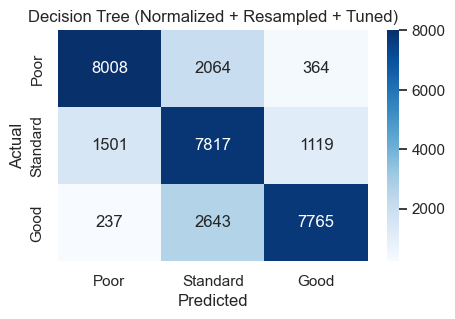

In [119]:
# Parameter grids
dt_paramGrid = (ParamGridBuilder()
            .addGrid(dt_oversample.impurity, ['gini', 'entropy'])
            .addGrid(dt_oversample.maxDepth, [5, 10, 15])
            .addGrid(dt_oversample.maxBins, [2,4])
            .build())

dt_crossval = CrossValidator(estimator=dt_pipeline_oversample,
                          estimatorParamMaps=dt_paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

# Train the model using the training set find the best parameters for the model from the parameter grid
dt_tunedDTModel = crossval.fit(train_resampled)
dt_best_model_over = tunedDTModel.bestModel

# Extract the Decision Tree classifier from the pipeline
best_dt_model_over = dt_best_model_over.stages[-1]

# Display tuned model's performance
dt_tuned_over_predictions = dt_best_model_over.transform(test_resampled)

dt_predictionAndLabels_oversample_tuned = dt_tuned_over_predictions.select("prediction", "Credit_Score_index").rdd
dt_metrics_oversample_tuned = MulticlassMetrics(dt_predictionAndLabels_oversample_tuned)
dt_confusion_matrix_oversample_tuned = dt_metrics_oversample_tuned.confusionMatrix()

print(f"Tuned predictions for {best_dt_model_over}:")
print(f"Best DT Impurity: {best_dt_model_over.getImpurity()}")
print(f"Best DT Min Instances Per Node: {best_dt_model_over.getMinInstancesPerNode()}")
print(f"Best DT Max Bins: {best_dt_model_over.getMaxBins()}")
print()
print(model_summary('Decision Tree (Normalized + Resampled + Tuned)', dt_tuned_over_predictions))
confusion_matrix_plot('Decision Tree (Normalized + Resampled + Tuned)', dt_confusion_matrix_oversample_tuned.toArray())

### Comparison of the results

In [120]:
dt_basic_summary = model_summary('Decision Tree (Basic)', dt_results_default)
dt_basic_tuned_summary = model_summary('Decision Tree (Tuned)', dt_tuned_predictions)
dt_normalized_summary = model_summary('Decision Tree (Normalized)', dt_results_normalize)
dt_normalized_tuned_summary = model_summary('Decision Tree (Tuned + Normalized)', dt_tuned_normalized_predictions)
dt_resampled_summary = model_summary('Decision Tree (Normalized + Resampled)', dt_results_oversample)
dt_resampled_tuned_summary = model_summary('Decision Tree (Tuned + Normalized + Resampled)', dt_tuned_over_predictions)

dt_summary = pd.concat([dt_basic_summary, dt_basic_tuned_summary, dt_normalized_summary, dt_normalized_tuned_summary, dt_resampled_summary, dt_resampled_tuned_summary])
dt_summary

,Model,Accuracy,ROC-AUC Score,Precision (Overall),Recall (Overall),F1-score (Overall)
0,Decision Tree (Basic),0.690732,0.779277,0.731452,0.619798,0.688749
0,Decision Tree (Tuned),0.713620,0.807380,0.708738,0.698070,0.713830
0,Decision Tree (Normalized),0.691347,0.778566,0.739093,0.612006,0.689290
0,Decision Tree (Tuned + Normalized),0.702970,0.795680,0.697517,0.676642,0.703333
0,Decision Tree (Normalized + Resampled),0.714957,0.831554,0.735768,0.783921,0.710115
0,Decision Tree (Tuned + Normalized + Resampled),0.748461,0.875471,0.821670,0.767344,0.751906


## Random Forest

### Before tuning, original data

+--------------------+------------------+--------------------+--------------------+--------------------+----------+
|            features|Credit_Score_index|     features_scaled|       rawPrediction|         probability|prediction|
+--------------------+------------------+--------------------+--------------------+--------------------+----------+
|[1.0,32.0,28806.0...|               1.0|[-1.5186985063700...|[2.00265155566961...|[0.10013257778348...|       1.0|
|[8.0,44.0,37464.0...|               1.0|[1.53591975094968...|[14.5397312906727...|[0.72698656453363...|       0.0|
|[5.0,29.0,20790.0...|               0.0|[0.22679764066981...|[2.53269485329153...|[0.12663474266457...|       1.0|
|[1.0,55.0,176015....|               1.0|[-1.5186985063700...|[2.95401759216555...|[0.14770087960827...|       2.0|
|[5.0,40.0,31357.0...|               1.0|[0.22679764066981...|[2.89497095158733...|[0.14474854757936...|       2.0|
+--------------------+------------------+--------------------+----------

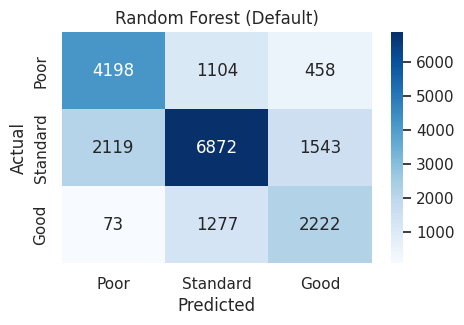

In [121]:
rf_original = RandomForestClassifier(labelCol="Credit_Score_index", featuresCol="features")

rf_model_original = rf_original.fit(train)

rf_predictions_original = rf_model_original.transform(test)

rf_predictions_original.show(5)

# Select (prediction, true label) and compute test error
rf_accuracy_original = evaluator.evaluate(rf_predictions_original)

rf_predictionAndLabels_original = rf_predictions_original.select("prediction", "Credit_Score_index").rdd
rf_metrics_original = MulticlassMetrics(rf_predictionAndLabels_original)
rf_confusion_matrix_original = rf_metrics_original.confusionMatrix()

print("Accuracy (untuned, original data) : ", rf_accuracy_original)

print(rf_model_original)
confusion_matrix_plot('Random Forest (Default)', rf_confusion_matrix_original.toArray())

### Before tuning, scaled data

+--------------------+------------------+--------------------+--------------------+--------------------+----------+
|            features|Credit_Score_index|     features_scaled|       rawPrediction|         probability|prediction|
+--------------------+------------------+--------------------+--------------------+--------------------+----------+
|[1.0,32.0,28806.0...|               1.0|[-1.5186985063700...|[1.87315815888543...|[0.09365790794427...|       1.0|
|[8.0,44.0,37464.0...|               1.0|[1.53591975094968...|[13.9795189790512...|[0.69897594895256...|       0.0|
|[5.0,29.0,20790.0...|               0.0|[0.22679764066981...|[2.58103348359119...|[0.12905167417955...|       1.0|
|[1.0,55.0,176015....|               1.0|[-1.5186985063700...|[3.11353708249468...|[0.15567685412473...|       2.0|
|[5.0,40.0,31357.0...|               1.0|[0.22679764066981...|[3.15482926461685...|[0.15774146323084...|       2.0|
+--------------------+------------------+--------------------+----------

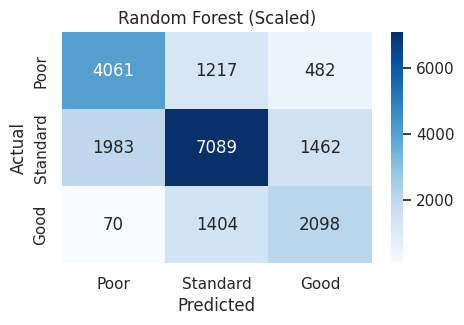

In [122]:
rf_scaled = RandomForestClassifier(labelCol="Credit_Score_index", featuresCol="features_scaled")

rf_model_scaled = rf_scaled.fit(train)

rf_predictions_scaled = rf_model_scaled.transform(test)

rf_predictions_scaled.show(5)

# Select (prediction, true label) and compute test error
rf_accuracy_scaled = evaluator.evaluate(rf_predictions_scaled)
print("Accuracy (untuned, scaled data) : ", rf_accuracy_scaled)

rf_predictionAndLabels_scaled = rf_predictions_scaled.select("prediction", "Credit_Score_index").rdd
rf_metrics_scaled = MulticlassMetrics(rf_predictionAndLabels_scaled)
rf_confusion_matrix_scaled = rf_metrics_scaled.confusionMatrix()

print(rf_model_scaled)
confusion_matrix_plot('Random Forest (Scaled)', rf_confusion_matrix_scaled.toArray())

### Before tuning, Scaled data & Over-sampled Data

+--------------------+------------------+--------------------+--------------------+--------------------+----------+
|            features|Credit_Score_index|     features_scaled|       rawPrediction|         probability|prediction|
+--------------------+------------------+--------------------+--------------------+--------------------+----------+
|[4.0,49.0,37188.0...|               2.0|[-0.2266189181776...|[2.28720054545465...|[0.11436002727273...|       2.0|
|[4.0,34.0,26150.0...|               1.0|[-0.2266189181776...|[2.41294334551094...|[0.12064716727554...|       2.0|
|[1.0,47.0,22323.0...|               2.0|[-1.5380129164670...|[2.13584680041438...|[0.10679234002071...|       2.0|
|[5.0,36.0,49216.0...|               1.0|[0.21051241458542...|[14.0580955083855...|[0.70290477541927...|       0.0|
|[8.0,35.0,72331.0...|               2.0|[1.52190641287477...|[2.24558317077188...|[0.11227915853859...|       2.0|
+--------------------+------------------+--------------------+----------

Accuracy (untuned, scaled and oversampled) :  0.7139800509738523


RandomForestClassificationModel: uid=RandomForestClassifier_5562fd1b855b, numTrees=20, numClasses=3, numFeatures=21


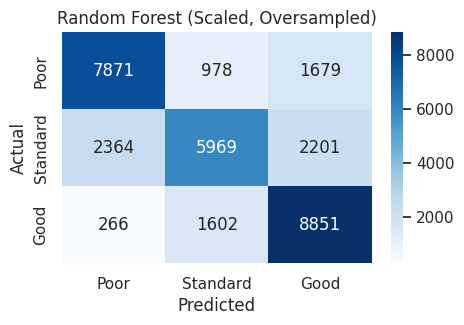

In [123]:
rf_model_scaled_resample = rf_scaled.fit(train_resampled)

rf_predictions_scaled_resample = rf_model_scaled_resample.transform(test_resampled)

rf_predictions_scaled_resample.show(5)

# Select (prediction, true label) and compute test error
rf_accuracy_scaled_resample = evaluator.evaluate(rf_predictions_scaled_resample)
print("Accuracy (untuned, scaled and oversampled) : ",  rf_accuracy_scaled_resample)

rf_predictionAndLabels_scaled_resample = rf_predictions_scaled_resample.select("prediction", "Credit_Score_index").rdd
rf_metrics_scaled_resample = MulticlassMetrics(rf_predictionAndLabels_scaled_resample)
rf_confusion_matrix_scaled_resample = rf_metrics_scaled_resample.confusionMatrix()

print(rf_model_scaled_resample)
confusion_matrix_plot('Random Forest (Scaled, Oversampled)', rf_confusion_matrix_scaled_resample.toArray())

### Hyper-parameter tuning the Random Forest Model with scaled & over-sampled data

Tuned model accuracy (scaled and oversampled): 0.8937730090305529


Best number of trees: 100
Best max depth: 20


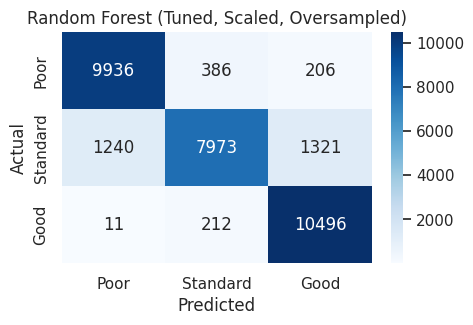

In [124]:
# Define the parameter grid to search
rf_paramGrid = (ParamGridBuilder()
             .addGrid(rf_scaled.numTrees, [50, 100])  # Number of trees
             .addGrid(rf_scaled.maxDepth, [5, 10, 20])     # Maximum depth of each tree
             .build())

# Define the evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="Credit_Score_index", predictionCol="prediction", metricName="accuracy")

# Define CrossValidator
rf_cv_scaled_resample = CrossValidator(estimator=rf_scaled,
                    estimatorParamMaps=rf_paramGrid,
                    evaluator=evaluator,
                    numFolds=5)  # K-fold cross-validation

# Fit the model using CrossValidator
rf_cvModel_scaled_resample = rf_cv_scaled_resample.fit(train_resampled)

# Make predictions on the test data
rf_predictions_cv_scaled_resample = rf_cvModel_scaled_resample.transform(test_resampled)

# Evaluate the tuned model
rf_accuracy_cv_scaled_resample = evaluator.evaluate(rf_predictions_cv_scaled_resample)
print("Tuned model accuracy (scaled and oversampled):", rf_accuracy_cv_scaled_resample)

# Convert DataFrame to RDD for MulticlassMetrics
rf_predictionAndLabels_cv_scaled_resample = rf_predictions_cv_scaled_resample.select("prediction", "Credit_Score_index").rdd
rf_metrics_cv_scaled_resample = MulticlassMetrics(rf_predictionAndLabels_cv_scaled_resample)
rf_confusion_matrix_cv_scaled_resample = rf_metrics_cv_scaled_resample.confusionMatrix()

# Get the best parameters
rf_bestModel_scaled_resample = rf_cvModel_scaled_resample.bestModel
rf_bestNumTrees_scaled_resample = rf_bestModel_scaled_resample.getNumTrees
rf_bestMaxDepth_scaled_resample = rf_bestModel_scaled_resample.getMaxDepth()
print("Best number of trees:", rf_bestNumTrees_scaled_resample)
print("Best max depth:", rf_bestMaxDepth_scaled_resample)

confusion_matrix_plot('Random Forest (Tuned, Scaled, Oversampled)', rf_confusion_matrix_cv_scaled_resample.toArray())

### Comparison of the results

In [125]:
rfc_basic_summary = model_summary('Random Forest (Basic)', rf_predictions_original)
rfc_scaled_summary = model_summary('Random Forest (Normalized)', rf_predictions_scaled)
rfc_resampled_summary = model_summary('Random Forest (Resampled)', rf_predictions_scaled_resample)
rfc_tuned_scaled_over_summary = model_summary('Random Forest (Tuned + Normalized + Resampled)', rf_predictions_cv_scaled_resample)

rfc_summary = pd.concat([rfc_basic_summary, rfc_scaled_summary, rfc_resampled_summary, rfc_tuned_scaled_over_summary])
rfc_summary

,Model,Accuracy,ROC-AUC Score,Precision (Overall),Recall (Overall),F1-score (Overall)
0,Random Forest (Basic),0.669083,0.789323,0.656964,0.728819,0.671179
0,Random Forest (Normalized),0.666868,0.781217,0.664213,0.705035,0.668779
0,Random Forest (Resampled),0.713980,0.807687,0.749548,0.747625,0.709939
0,Random Forest (Tuned + Normalized + Resampled),0.893773,0.948878,0.888174,0.943769,0.891125


# 6. Model Evaluation

In [126]:
# Show the summary of all models
overall_summary = pd.concat([lr_summary, ann_summary, dt_summary, rfc_summary])
overall_summary

,Model,Accuracy,ROC-AUC Score,Precision (Overall),Recall (Overall),F1-score (Overall)
0,Logistic Regression (Basic),0.643864,0.737523,0.684541,0.529687,0.635806
0,Logistic Regression (Normalized),0.641800,0.733582,0.685228,0.517014,0.633117
0,Logistic Regression (Resampled),0.672068,0.796285,0.723306,0.683321,0.667946
0,Logistic Regression (Tuned),0.642001,0.734438,0.683925,0.525174,0.633096
0,Logistic Regression (Tuned + Normalized),0.640844,0.732612,0.684536,0.518750,0.631498
0,Logistic Regression (Tuned + Normalized + Resa...,0.677606,0.796808,0.729624,0.707447,0.671606
0,ANN (Basic),0.566974,0.652626,0.557625,0.450682,0.502944
0,ANN (Normalized),0.693088,0.785059,0.709998,0.645121,0.692092
0,ANN (Resampled),0.526080,0.734301,0.632194,0.657819,0.423160
0,ANN (Normalized + Resampled),0.708897,0.826288,0.748706,0.762553,0.704427


In [127]:
# Show the summary, sort by Accuracy
overall_summary.sort_values(by=['Accuracy'])

,Model,Accuracy,ROC-AUC Score,Precision (Overall),Recall (Overall),F1-score (Overall)
0,ANN (Resampled),0.526080,0.734301,0.632194,0.657819,0.423160
0,ANN (Basic),0.566974,0.652626,0.557625,0.450682,0.502944
0,Logistic Regression (Tuned + Normalized),0.640844,0.732612,0.684536,0.518750,0.631498
0,Logistic Regression (Normalized),0.641800,0.733582,0.685228,0.517014,0.633117
0,Logistic Regression (Tuned),0.642001,0.734438,0.683925,0.525174,0.633096
0,Logistic Regression (Basic),0.643864,0.737523,0.684541,0.529687,0.635806
0,Random Forest (Normalized),0.666868,0.781217,0.664213,0.705035,0.668779
0,Random Forest (Basic),0.669083,0.789323,0.656964,0.728819,0.671179
0,Logistic Regression (Resampled),0.672068,0.796285,0.723306,0.683321,0.667946
0,Logistic Regression (Tuned + Normalized + Resa...,0.677606,0.796808,0.729624,0.707447,0.671606


In [128]:
# Show the best accuracy models of each implementations
lr_highest_accuracy = lr_summary[lr_summary['Accuracy'] == lr_summary['Accuracy'].max()]
ann_highest_accuracy = ann_summary[ann_summary['Accuracy'] == ann_summary['Accuracy'].max()]
dt_highest_accuracy = dt_summary[dt_summary['Accuracy'] == dt_summary['Accuracy'].max()]
rfc_highest_accuracy = rfc_summary[rfc_summary['Accuracy'] == rfc_summary['Accuracy'].max()]
best_model_summary = pd.concat([lr_highest_accuracy, ann_highest_accuracy, dt_highest_accuracy, rfc_highest_accuracy])
best_model_summary.sort_values(by=['Accuracy'])

,Model,Accuracy,ROC-AUC Score,Precision (Overall),Recall (Overall),F1-score (Overall)
0,Logistic Regression (Tuned + Normalized + Resa...,0.677606,0.796808,0.729624,0.707447,0.671606
0,ANN (Tuned + Normalized + Resampled),0.712218,0.825597,0.733138,0.782580,0.706118
0,Decision Tree (Tuned + Normalized + Resampled),0.748461,0.875471,0.821670,0.767344,0.751906
0,Random Forest (Tuned + Normalized + Resampled),0.893773,0.948878,0.888174,0.943769,0.891125


## Conclusion

We can find that the accuracy of the all four models increased after the data has normalized and oversampled, and hyperparameters were tuned.

Among them, the model that showed the greatest performance improvement was the ANN model, which recorded an accuracy of 71.2% based on ANN (Tuned + Normalized + Resampled) from an accuracy of about 52.6% based on the original data, showing a significant increase of approximately 18.6%p.

The model that showed the highest accuracy among the four models was the Random forest model, which showed 89.4% accuracy.

## Spark MLlib vs Scikit-learn

Spark MLlib is optimal for distributed systems, making it inherently more scalable and suitable for much heavier workloads compared to scikit-learn.

While scikit-learn by default provides much better default parameters and more parameter options. This makes it both easier to create better models and to tune models to a finer degree for better results.